<a href="https://colab.research.google.com/github/RitaROK/Analysis/blob/main/Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install uncertainties

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 98 kB 3.6 MB/s 


In [2]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.
import uncertainties.unumpy as unp 
import scipy
from sklearn.metrics import mean_squared_error, r2_score

def get_color(n, basecolor):
  current_palette = sns.dark_palette(n_colors=n, color=basecolor)
  sns.palplot(current_palette)
  colors = np.zeros(n, dtype=object)
  for color in range(n):
    colors[color] = current_palette[color]
  return colors

In [3]:
roi = pd.read_csv('/content/drive/MyDrive/LIME/roi.csv')
original = pd.read_csv('/content/drive/MyDrive/LIME/sc.csv')
roi['R']=np.sqrt((roi['xMean']-(2304/2))**2+(roi['yMean']-(2304/2))**2) # Distance from the center
roi['TSigma'] = roi['TSigma']*155
roi['LSigma'] = roi['LSigma']*155
roi.describe()

,z[cm],Hits,Integral,Length,Width,Slim,PathLen,CorrIntegral,xMax,xMin,...,LAmp,LMean,LSigma,Long_RMS,MAmp,MFWHM,MMean,MProm,Pixel,R
count,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.0,251440.000000,251440.000000,251440.000000,...,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000,251440.000000
mean,24.402303,406.991577,7387.418094,37.527159,31.462311,0.840268,-1.0,28709.457663,1423.350016,1389.534839,...,1093.674008,18.637897,956.374380,5.878410,1228.683430,5.574327,18.819076,1162.892885,7129.694050,575.906634
std,12.406499,110.683815,1835.943276,4.963289,4.798911,0.086205,0.0,7095.156578,556.467129,556.087405,...,214.779881,3.070184,167.891613,0.917130,240.512170,1.734003,3.881874,247.476867,4599.808717,275.250941
min,0.000000,100.000000,1456.721000,19.000000,14.569679,0.600019,-1.0,6002.030000,223.000000,204.000000,...,300.603300,8.045532,406.694766,2.300020,403.312230,2.000282,5.500000,400.121250,0.000000,1.943643
25%,15.000000,326.000000,6137.715575,34.358808,27.888294,0.782432,-1.0,24335.557750,987.000000,952.000000,...,955.646050,16.560118,840.511405,5.259190,1072.313125,4.029987,16.000000,1001.251877,3424.000000,343.863777
50%,25.000000,412.000000,7534.881300,37.915604,31.737520,0.848713,-1.0,29134.941500,1519.000000,1484.000000,...,1092.255700,18.576963,964.927359,5.943493,1213.978650,5.707380,19.000000,1150.739000,6704.000000,575.465301
75%,35.000000,490.000000,8730.483500,41.027379,35.124967,0.901700,-1.0,33431.991500,1907.000000,1872.000000,...,1225.771125,20.597599,1075.545314,6.538057,1374.043250,6.965137,21.500000,1313.813050,10224.000000,813.210276
max,45.000000,798.000000,15159.720000,49.996555,49.548534,1.000000,-1.0,59992.797000,2207.000000,2192.000000,...,1994.883800,29.997269,1548.184175,8.998210,2093.593300,10.982183,35.000000,1999.858400,29472.000000,1175.128896


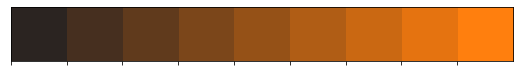

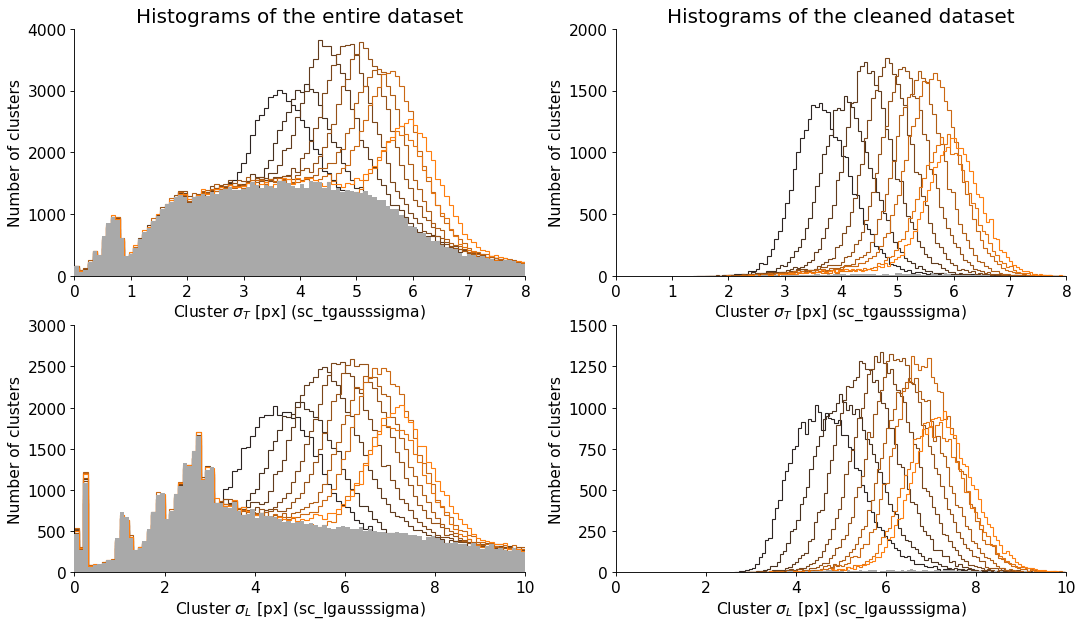

In [4]:
#@title Influence of Data Cleaning 
nbin=100
color = get_color(9, 'tab:orange')
i=0

fig, (ax) = plt.subplots(2,2, figsize=(16,9), dpi= 80, facecolor='w', edgecolor='k') 
ax[0][0].set_title('Histograms of the entire dataset', fontsize=18)
ax[0][1].set_title('Histograms of the cleaned dataset', fontsize=18)

ax[0][0].hist(original['TSigma'].loc[(original['z[cm]']==0) & (original['TSigma']<8)], bins=nbin, color='darkgray', zorder=5)
ax[0][1].hist(roi['TSigma'].loc[roi['z[cm]']==0]/155, bins=nbin, color='darkgray', zorder=5)
ax[1][0].hist(original['LSigma'].loc[(original['z[cm]']==0) & (original['LSigma']<10)], bins=nbin, color='darkgray', zorder=5)
ax[1][1].hist(roi['LSigma'].loc[roi['z[cm]']==0]/155, bins=nbin, color='darkgray', zorder=5)

for dist in [5, 10, 15, 20, 25, 30, 35, 40, 45]:
  ax[0][0].hist(original['TSigma'].loc[(original['z[cm]']==dist) & (original['TSigma']<8)], bins=nbin, histtype='step', lw=1, color=color[i])
  ax[0][1].hist(roi['TSigma'].loc[roi['z[cm]']==dist]/155, bins=nbin, histtype='step', lw=1, color=color[i])
  ax[1][0].hist(original['LSigma'].loc[(original['z[cm]']==dist) & (original['LSigma']<10)], bins=nbin, histtype='step', lw=1, color=color[i])
  ax[1][1].hist(roi['LSigma'].loc[roi['z[cm]']==dist]/155, bins=nbin, histtype='step', lw=1, color=color[i])
  i=i+1

ax[0][0].set_xlim(0,8)
ax[0][0].spines["right"].set_visible(False)
ax[0][0].spines["top"].set_visible(False)
ax[0][0].set_ylabel('Number of clusters', y=0.5, ha='center', fontsize=14)
ax[0][0].tick_params(axis='both', which='major', labelsize=14)
ax[0][0].set_xlabel('Cluster $\sigma_T$ [px] (sc_tgausssigma)', x=0.5, ha='center', fontsize=14)
ax[0][0].set_ylim(0,4e3)

ax[1][0].set_xlim(0,10)
ax[1][0].spines["right"].set_visible(False)
ax[1][0].spines["top"].set_visible(False)
ax[1][0].set_ylabel('Number of clusters', y=0.5, ha='center', fontsize=14)
ax[1][0].tick_params(axis='both', which='major', labelsize=14)
ax[1][0].set_xlabel('Cluster $\sigma_L$ [px] (sc_lgausssigma)', x=0.5, ha='center', fontsize=14)
ax[1][0].set_ylim(0,3e3)

ax[0][1].set_xlim(0,8)
ax[0][1].spines["right"].set_visible(False)
ax[0][1].spines["top"].set_visible(False)
ax[0][1].set_ylabel('Number of clusters', y=0.5, ha='center', fontsize=14)
ax[0][1].tick_params(axis='both', which='major', labelsize=14)
ax[0][1].set_xlabel('Cluster $\sigma_T$ [px] (sc_tgausssigma)', x=0.5, ha='center', fontsize=14)
ax[0][1].set_ylim(0,2e3)

ax[1][1].set_xlim(0,10)
ax[1][1].spines["right"].set_visible(False)
ax[1][1].spines["top"].set_visible(False)
ax[1][1].set_ylabel('Number of clusters', y=0.5, ha='center', fontsize=14)
ax[1][1].tick_params(axis='both', which='major', labelsize=14)
ax[1][1].set_xlabel('Cluster $\sigma_L$ [px] (sc_lgausssigma)', x=0.5, ha='center', fontsize=14)
ax[1][1].set_ylim(0,1.5e3)

plt.show()

In [5]:
#@title Fitting functions

def gauss(x,A,x0,s):
    return A*np.exp(-(x-x0)**2/(2*s**2))

def fit_tsigma(data, nbin, variable):
  fig, (ax) = plt.subplots(2,5, figsize=(24,9), dpi= 80, facecolor='w', edgecolor='k') 
  # Background
  display('#'*100)
  print('BACKGROUND')
  n, bins, patches = ax[0][0].hist(data[variable].loc[data['z[cm]']==0], bins=nbin, color='darkgray', zorder=5)
  bin_middles = (bins[1:]+bins[:-1])/2
  x = np.linspace(0,2000, 2000)
  bpopt, bpcov = curve_fit(gauss, bin_middles, n, p0=[data[variable].loc[data['z[cm]']==0].max(), data[variable].loc[data['z[cm]']==0].mean(), 10])
  bpcov = np.sqrt(np.diag(bpcov))
  ycalc = gauss(x, *bpopt)
  print('A=', ufloat(bpopt[0], bpcov[0]))
  print('x0=', ufloat(bpopt[1], bpcov[1]))
  print('sigma=', ufloat(bpopt[2], bpcov[2]))
  #def double_gauss(x,A,X0,S):
  #  return A*np.exp(-(x-X0)**2/(2*S**2))+abs(bpopt[0])*np.exp(-(x-abs(bpopt[1]))**2/(2*abs(bpopt[2])**2))
  rmse = np.sqrt(mean_squared_error(n, gauss(np.asarray(bin_middles), *bpopt)))
  print('RMSE = ', rmse)
  
  ax[0][0].plot(x, ycalc, color='k', zorder=5)
  sigma = []
  dsigma = []
  i = 1
  j = 0
  for depth in [5, 10, 15, 20, 25, 30, 35, 40, 45]:
    # Background
    ax[j][i].hist(data[variable].loc[data['z[cm]']==0], bins=nbin, color='darkgray', zorder=5)
    # Signal
    display('#'*100)
    print('Z = ', depth)
    n, bins, patches = ax[j][i].hist(data[variable].loc[data['z[cm]']==depth], bins=nbin, histtype='step', lw=1, color='tab:orange', label = 'Z='+str(depth)+'cm')
    bin_middles = (bins[1:]+bins[:-1])/2
    popt, pcov = curve_fit(gauss, bin_middles, n, p0=[data[variable].loc[data['z[cm]']==depth].max(), data[variable].loc[data['z[cm]']==depth].mean(), 10])
    ycalc = gauss(x, *popt)
    pcov = np.sqrt(np.diag(pcov))
    print('A =', ufloat(popt[0], pcov[0]))
    print('x0 = ', ufloat(popt[1], pcov[1]))
    print('sigma = ', ufloat(popt[2], pcov[2]))
    sigma.append(popt[1])
    dsigma.append(pcov[1])
    rmse = np.sqrt(mean_squared_error(n, gauss(np.asarray(bin_middles), *popt)))
    print('RMSE = ', rmse)
    ax[j][i].plot(x, ycalc, color='k', zorder=5)
    ax[j][i].legend(loc='best')
    i=i+1
    if i>4:
      j = 1
      i = i-5
  plt.show()
  return sigma, dsigma

# Transverse Diffusion

'####################################################################################################'

BACKGROUND
A= 7.72+/-0.32
x0= 741+/-9
sigma= 183+/-9
RMSE =  2.1603749948731457


'####################################################################################################'

Z =  5
A = 682+/-5
x0 =  568.4+/-0.6
sigma =  76.4+/-0.6
RMSE =  19.371282524686016


'####################################################################################################'

Z =  10
A = 694+/-4
x0 =  635.8+/-0.5
sigma =  72.0+/-0.5
RMSE =  15.87951866569104


'####################################################################################################'

Z =  15
A = 836+/-5
x0 =  694.8+/-0.5
sigma =  68.7+/-0.5
RMSE =  20.41954186032015


'####################################################################################################'

Z =  20
A = 847+/-4
x0 =  750.6+/-0.4
sigma =  68.5+/-0.4
RMSE =  17.190253194602786


'####################################################################################################'

Z =  25
A = 821+/-5
x0 =  795.3+/-0.5
sigma =  68.7+/-0.5
RMSE =  19.53057170710694


'####################################################################################################'

Z =  30
A = 795+/-4
x0 =  834.6+/-0.4
sigma =  69.7+/-0.4
RMSE =  16.490332602907483


'####################################################################################################'

Z =  35
A = 803+/-4
x0 =  871.8+/-0.4
sigma =  72.4+/-0.4
RMSE =  17.019604848953172


'####################################################################################################'

Z =  40
A = 541.4+/-3.4
x0 =  904.5+/-0.5
sigma =  73.6+/-0.5
RMSE =  14.290066506721102


'####################################################################################################'

Z =  45
A = 534.9+/-3.5
x0 =  928.0+/-0.6
sigma =  74.2+/-0.6
RMSE =  15.260966352436347


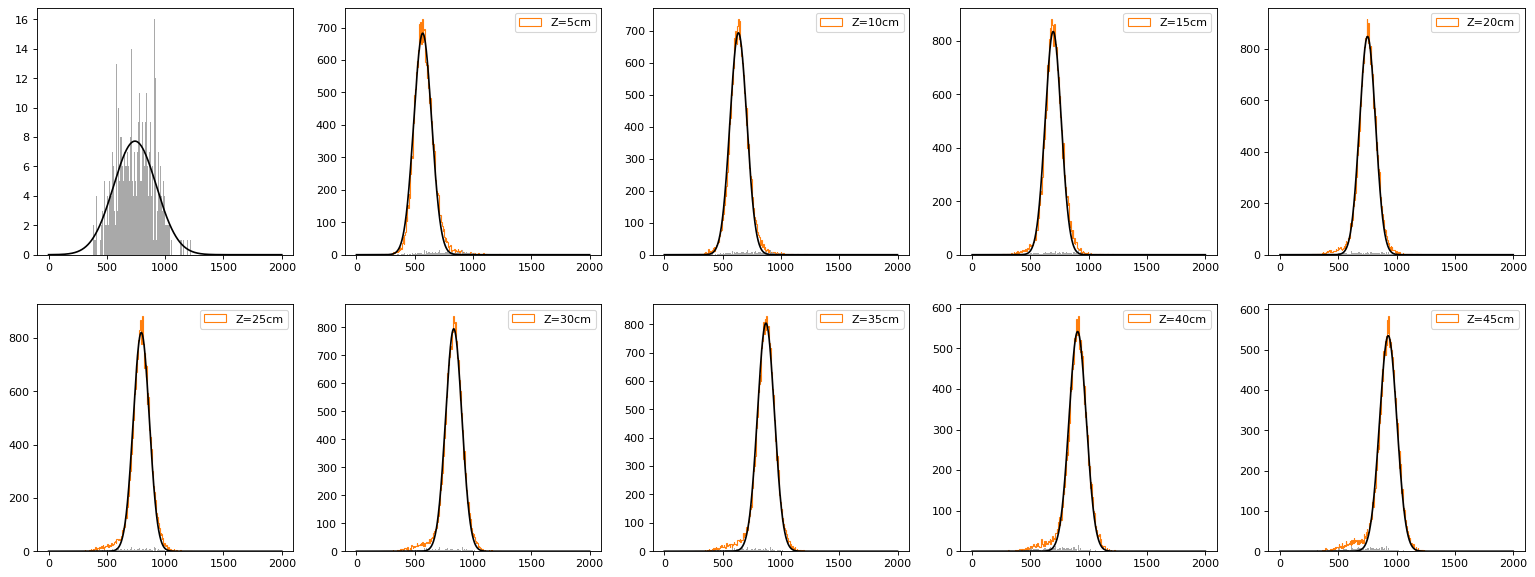

In [6]:
#@title Average $\sigma_T$ for all CoIs

allcoi, dallcoi = fit_tsigma(roi, 200, 'TSigma')

## Average $\sigma_T$ for different slices

'####################################################################################################'

BACKGROUND
A= 0.50+/-0.15
x0= 785+/-26
sigma= 77+/-26
RMSE =  0.418120301278098


'####################################################################################################'

Z =  5
A = 46.0+/-1.8
x0 =  573.8+/-3.1
sigma =  68.0+/-3.1
RMSE =  4.682595013024966


'####################################################################################################'

Z =  10
A = 51.9+/-1.5
x0 =  649.6+/-2.1
sigma =  63.3+/-2.1
RMSE =  3.409413116048336


'####################################################################################################'

Z =  15
A = 57.0+/-1.8
x0 =  703.0+/-2.3
sigma =  63.4+/-2.3
RMSE =  4.095786011517391


'####################################################################################################'

Z =  20
A = 74.1+/-1.5
x0 =  756.5+/-1.4
sigma =  57.1+/-1.4
RMSE =  3.18974910581876


'####################################################################################################'

Z =  25
A = 71.9+/-2.3
x0 =  805.3+/-2.2
sigma =  59.6+/-2.2
RMSE =  5.036931401504027


'####################################################################################################'

Z =  30
A = 64.8+/-1.6
x0 =  844.0+/-1.7
sigma =  59.5+/-1.7
RMSE =  3.302806296377335


'####################################################################################################'

Z =  35
A = 80.3+/-2.1
x0 =  888.0+/-1.8
sigma =  61.2+/-1.8
RMSE =  4.360856513283383


'####################################################################################################'

Z =  40
A = 46.7+/-1.0
x0 =  915.2+/-1.5
sigma =  60.1+/-1.5
RMSE =  2.2204662511532995


'####################################################################################################'

Z =  45
A = 65.6+/-1.8
x0 =  936.5+/-2.0
sigma =  -63.0+/-2.0
RMSE =  3.6730008569436357


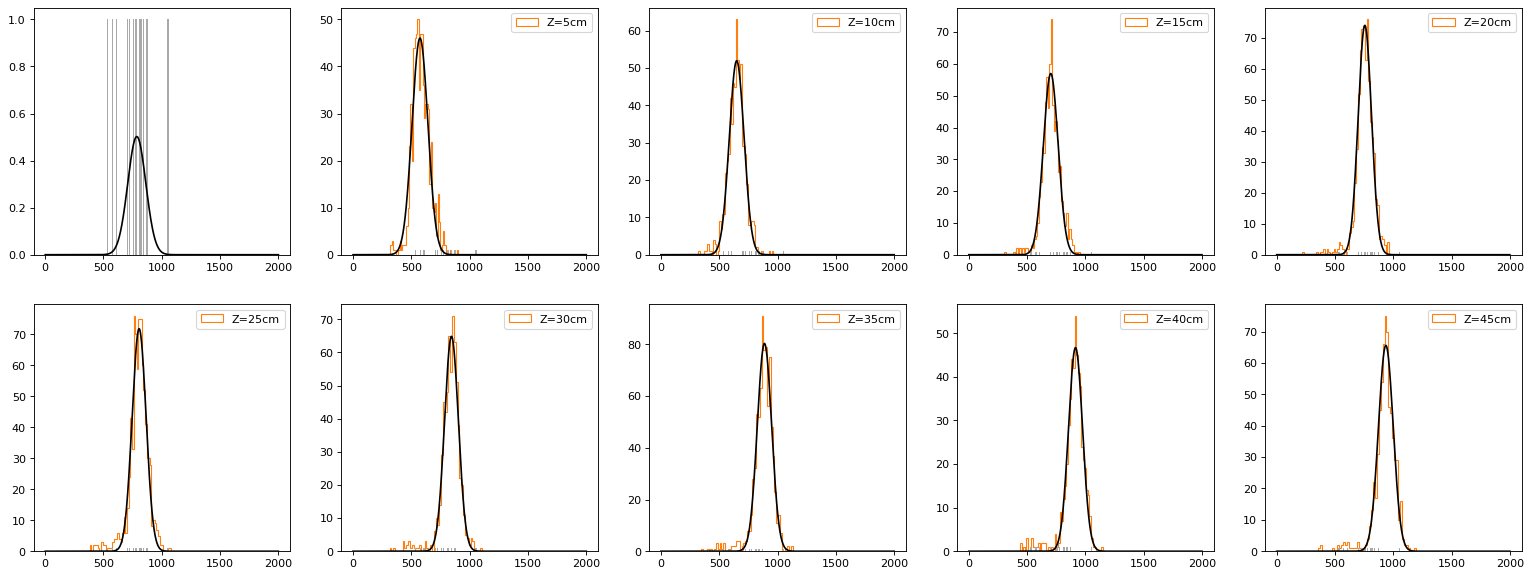

In [7]:
#@title $\sigma_T$ for $0\leq R\leq100$
coi100, dcoi100 = fit_tsigma(roi.loc[(roi['R']<=100)], 50, 'TSigma')

'####################################################################################################'

BACKGROUND
A= (0.0+/-2.1)e+06
x0= (0.0+/-1.3)e+10
sigma= (0.0+/-3.2)e+09
RMSE =  1.1747340124473857


'####################################################################################################'

Z =  5
A = 178+/-4
x0 =  570.4+/-1.5
sigma =  63.9+/-1.5
RMSE =  8.044537062390294


'####################################################################################################'

Z =  10
A = 155.6+/-2.8
x0 =  640.1+/-1.3
sigma =  64.7+/-1.3
RMSE =  6.310567533130245


'####################################################################################################'

Z =  15
A = 193.4+/-2.4
x0 =  699.4+/-0.9
sigma =  62.8+/-0.9
RMSE =  5.197059186145689


'####################################################################################################'

Z =  20
A = 202.2+/-3.5
x0 =  753.2+/-1.2
sigma =  59.9+/-1.2
RMSE =  7.564016111411757


'####################################################################################################'

Z =  25
A = 234+/-4
x0 =  796.6+/-1.3
sigma =  60.2+/-1.3
RMSE =  9.223997990895779


'####################################################################################################'

Z =  30
A = 192.2+/-3.2
x0 =  838.7+/-1.2
sigma =  60.0+/-1.2
RMSE =  6.748051344651936


'####################################################################################################'

Z =  35
A = 216.8+/-3.1
x0 =  873.9+/-1.0
sigma =  62.4+/-1.0
RMSE =  6.401168286535913


'####################################################################################################'

Z =  40
A = 130.0+/-2.4
x0 =  909.4+/-1.4
sigma =  63.9+/-1.4
RMSE =  5.468903680091311


'####################################################################################################'

Z =  45
A = 171.2+/-2.6
x0 =  935.0+/-1.2
sigma =  67.8+/-1.2
RMSE =  5.472183337705069


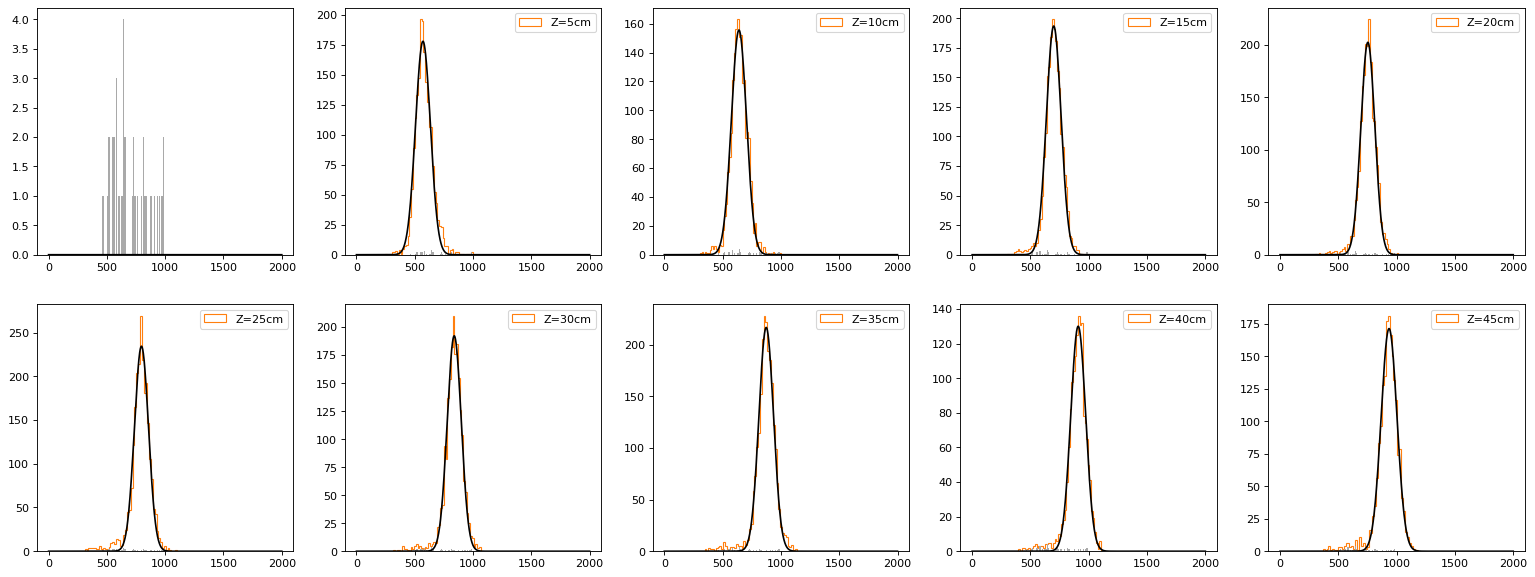

In [8]:
#@title $\sigma_T$ for $100<R\leq 200$
coi200, dcoi200 = fit_tsigma(roi.loc[(roi['R']<=200) & (roi['R']>100)], 50, 'TSigma')

'####################################################################################################'

BACKGROUND
A= 1.85+/-0.24
x0= 709+/-32
sigma= (1.9+/-0.4)e+02
RMSE =  0.9116515816085115


'####################################################################################################'

Z =  5
A = 218+/-5
x0 =  577.6+/-1.6
sigma =  66.2+/-1.6
RMSE =  11.070334790983908


'####################################################################################################'

Z =  10
A = 289+/-5
x0 =  644.6+/-1.3
sigma =  60.7+/-1.3
RMSE =  10.747677112078595


'####################################################################################################'

Z =  15
A = 330+/-5
x0 =  702.1+/-1.1
sigma =  58.9+/-1.1
RMSE =  10.551967834795219


'####################################################################################################'

Z =  20
A = 317+/-5
x0 =  758.9+/-1.0
sigma =  60.4+/-1.0
RMSE =  9.989344581017646


'####################################################################################################'

Z =  25
A = 305.5+/-3.2
x0 =  801.3+/-0.7
sigma =  59.5+/-0.7
RMSE =  6.729772832285838


'####################################################################################################'

Z =  30
A = 277+/-4
x0 =  836.5+/-1.0
sigma =  61.8+/-1.0
RMSE =  7.877183619718257


'####################################################################################################'

Z =  35
A = 308+/-4
x0 =  874.7+/-1.0
sigma =  63.7+/-1.0
RMSE =  8.495246945969605


'####################################################################################################'

Z =  40
A = 235+/-5
x0 =  907.9+/-1.4
sigma =  63.0+/-1.4
RMSE =  9.28293756146892


'####################################################################################################'

Z =  45
A = 240.3+/-3.4
x0 =  935.4+/-1.1
sigma =  66.2+/-1.1
RMSE =  7.372383008948855


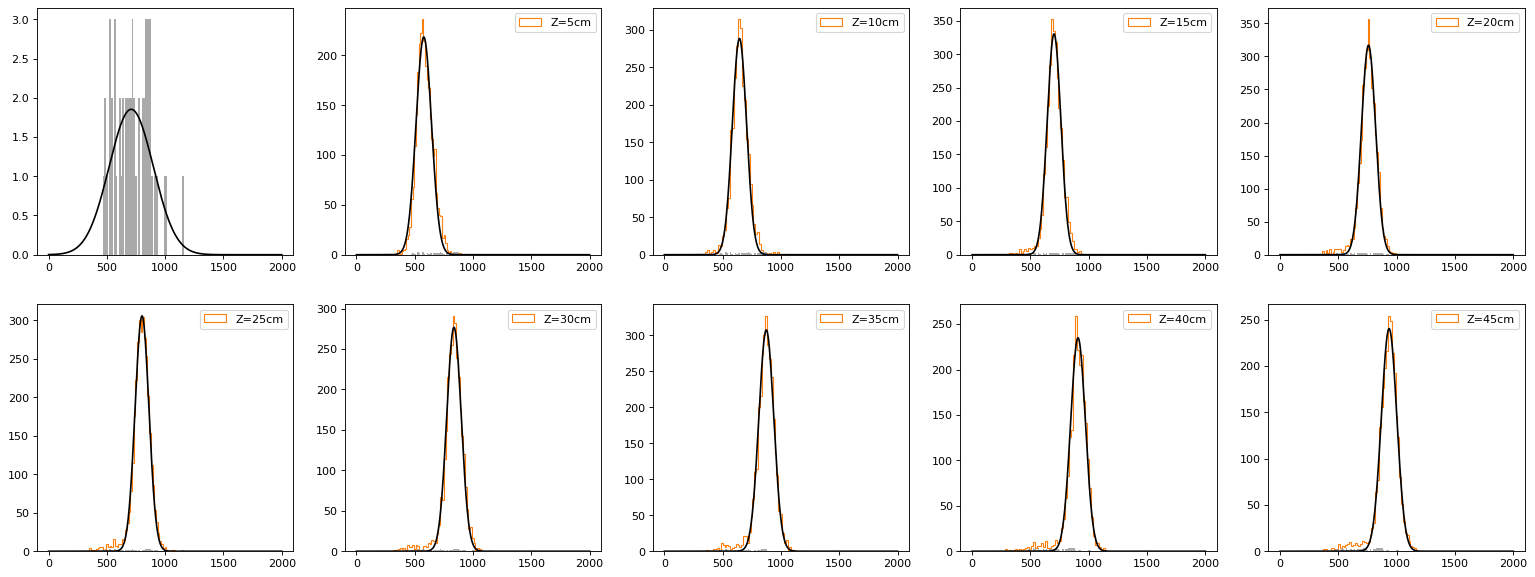

In [9]:
#@title $\sigma_T$ for $200<R\leq 300$
coi300, dcoi300 = fit_tsigma(roi.loc[(roi['R']<=300) & (roi['R']>200)], 50, 'TSigma')

'####################################################################################################'

BACKGROUND
A= (0.0+/-1.0)e+03
x0= (7.1+/-0.4)e+02
sigma= (0+/-9)e+01
RMSE =  0.4949747473652651


'####################################################################################################'

Z =  5
A = 69.3+/-0.9
x0 =  584.7+/-1.0
sigma =  67.1+/-1.0
RMSE =  3.855073276786233


'####################################################################################################'

Z =  10
A = 57.0+/-0.8
x0 =  644.6+/-1.0
sigma =  65.0+/-1.0
RMSE =  3.6931149509757084


'####################################################################################################'

Z =  15
A = 74.3+/-1.0
x0 =  701.8+/-1.0
sigma =  63.5+/-1.0
RMSE =  4.358291419322035


'####################################################################################################'

Z =  20
A = 88.9+/-1.2
x0 =  757.5+/-1.0
sigma =  61.3+/-1.0
RMSE =  5.0372556538199404


'####################################################################################################'

Z =  25
A = 76.4+/-1.0
x0 =  800.2+/-0.9
sigma =  61.8+/-0.9
RMSE =  4.304056096598083


'####################################################################################################'

Z =  30
A = 71.0+/-1.0
x0 =  839.2+/-1.1
sigma =  64.5+/-1.1
RMSE =  4.4093157281657875


'####################################################################################################'

Z =  35
A = 76.9+/-0.8
x0 =  875.1+/-0.8
sigma =  65.9+/-0.8
RMSE =  3.5008720369712005


'####################################################################################################'

Z =  40
A = 57.6+/-0.8
x0 =  906.2+/-1.0
sigma =  64.3+/-1.0
RMSE =  3.2616773412132876


'####################################################################################################'

Z =  45
A = 59.1+/-0.9
x0 =  928.7+/-1.2
sigma =  67.1+/-1.2
RMSE =  3.9622445266698776


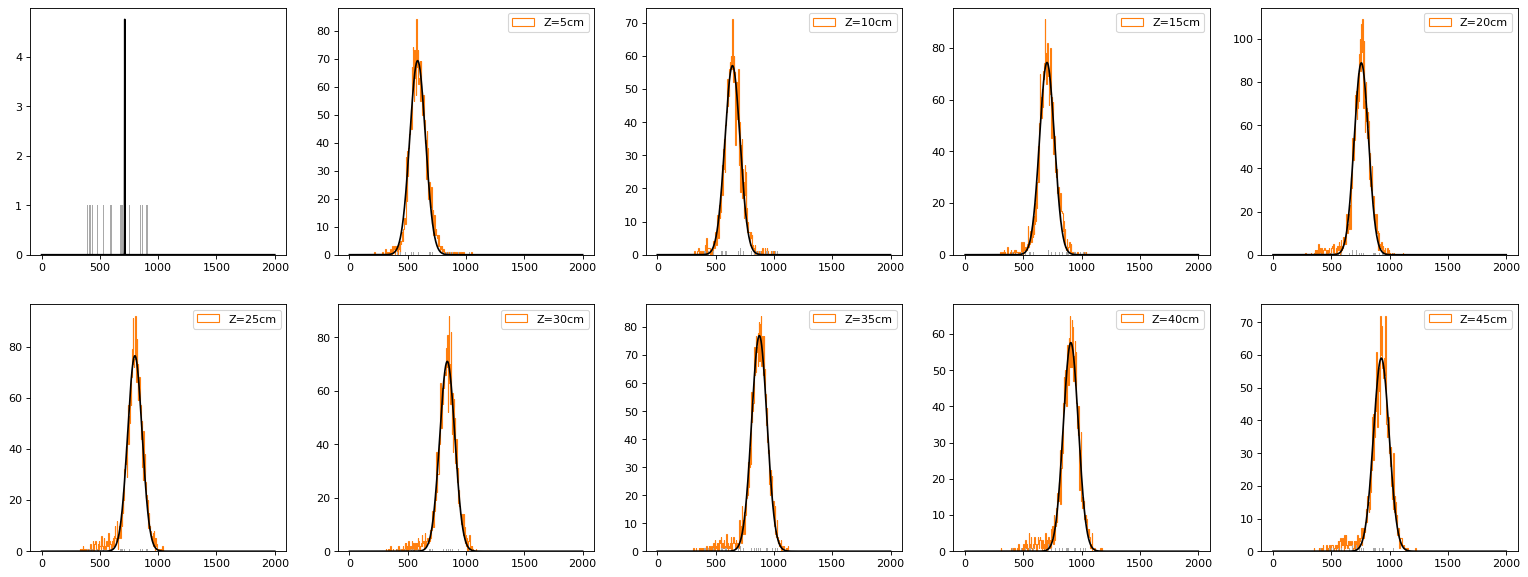

In [10]:
#@title $\sigma_T$ for $300<R\leq 400$
coi400, dcoi400 = fit_tsigma(roi.loc[(roi['R']<=400) & (roi['R']>300)], 200, 'TSigma')

'####################################################################################################'

BACKGROUND
A= 0.77+/-0.09
x0= 700+/-22
sigma= 166+/-25
RMSE =  0.671130056531554


'####################################################################################################'

Z =  5
A = 56.5+/-0.9
x0 =  577.4+/-1.4
sigma =  74.2+/-1.4
RMSE =  4.378324421552323


'####################################################################################################'

Z =  10
A = 70.3+/-1.0
x0 =  639.7+/-1.1
sigma =  69.4+/-1.1
RMSE =  4.1882346285645


'####################################################################################################'

Z =  15
A = 87.3+/-1.0
x0 =  697.6+/-0.9
sigma =  65.9+/-0.9
RMSE =  4.084185994635583


'####################################################################################################'

Z =  20
A = 71.4+/-1.0
x0 =  755.0+/-1.0
sigma =  64.9+/-1.0
RMSE =  4.360586779399209


'####################################################################################################'

Z =  25
A = 69.5+/-1.0
x0 =  794.8+/-1.1
sigma =  62.4+/-1.1
RMSE =  4.713492221655361


'####################################################################################################'

Z =  30
A = 66.1+/-0.7
x0 =  836.8+/-0.9
sigma =  66.1+/-0.9
RMSE =  3.4360486810452455


'####################################################################################################'

Z =  35
A = 83.7+/-1.1
x0 =  872.3+/-1.1
sigma =  68.1+/-1.1
RMSE =  4.796393372038954


'####################################################################################################'

Z =  40
A = 51.7+/-0.7
x0 =  903.3+/-1.1
sigma =  67.6+/-1.1
RMSE =  3.2477517886561627


'####################################################################################################'

Z =  45
A = 53.1+/-0.8
x0 =  922.0+/-1.2
sigma =  68.0+/-1.2
RMSE =  3.420496095406423


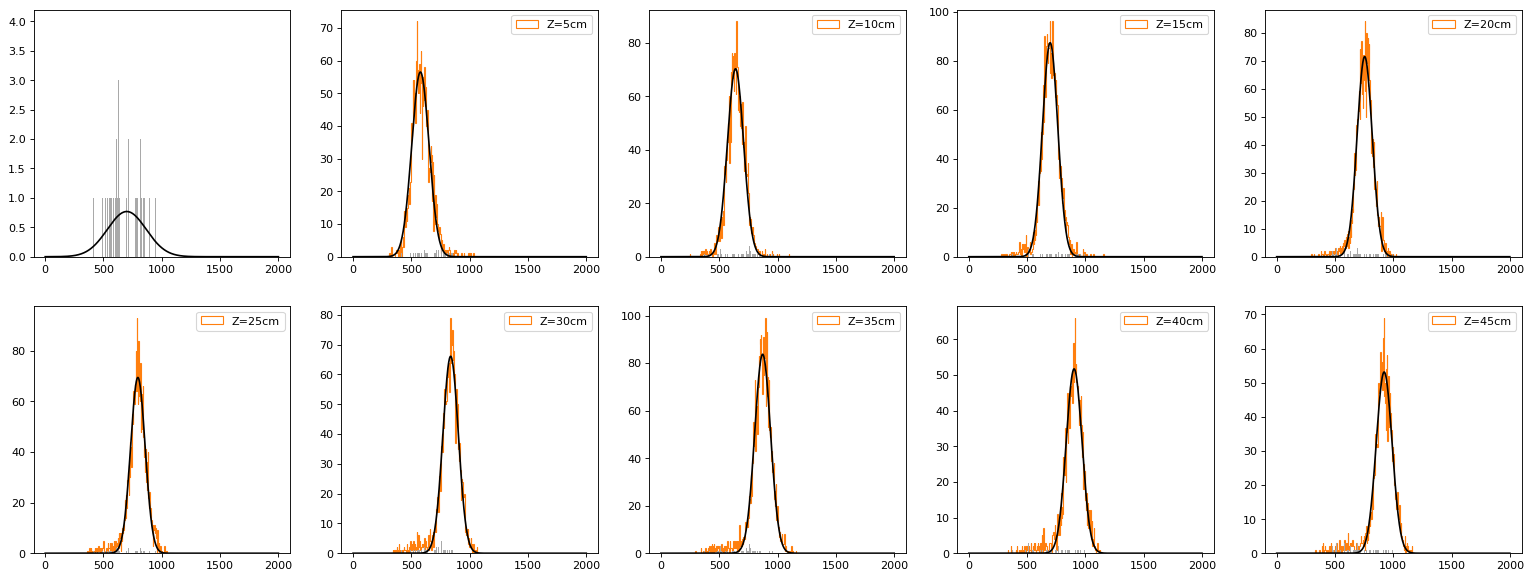

In [11]:
#@title $\sigma_T$ for $400<R\leq 500$
coi500, dcoi500 = fit_tsigma(roi.loc[(roi['R']<=500) & (roi['R']>400)], 200, 'TSigma')

'####################################################################################################'

BACKGROUND
A= 0.84+/-0.10
x0= 708+/-24
sigma= 178+/-24
RMSE =  0.6694973160258282


'####################################################################################################'

Z =  5
A = 56.2+/-0.8
x0 =  547.0+/-1.3
sigma =  77.1+/-1.3
RMSE =  3.89283972126374


'####################################################################################################'

Z =  10
A = 53.1+/-0.8
x0 =  618.1+/-1.2
sigma =  70.8+/-1.2
RMSE =  3.815501783996306


'####################################################################################################'

Z =  15
A = 74.4+/-1.1
x0 =  680.0+/-1.2
sigma =  71.0+/-1.2
RMSE =  4.916970784322283


'####################################################################################################'

Z =  20
A = 68.1+/-0.8
x0 =  738.5+/-0.9
sigma =  70.0+/-0.9
RMSE =  3.568573751089962


'####################################################################################################'

Z =  25
A = 72.0+/-0.8
x0 =  783.3+/-0.9
sigma =  68.9+/-0.9
RMSE =  3.6925903919231744


'####################################################################################################'

Z =  30
A = 62.8+/-0.9
x0 =  824.6+/-1.2
sigma =  69.4+/-1.2
RMSE =  4.271453471280351


'####################################################################################################'

Z =  35
A = 68.4+/-0.9
x0 =  860.6+/-1.2
sigma =  74.1+/-1.2
RMSE =  4.29896415013455


'####################################################################################################'

Z =  40
A = 54.9+/-0.9
x0 =  895.1+/-1.3
sigma =  73.1+/-1.3
RMSE =  3.8179838292631567


'####################################################################################################'

Z =  45
A = 52.1+/-0.8
x0 =  916.3+/-1.4
sigma =  72.8+/-1.4
RMSE =  3.764846122915895


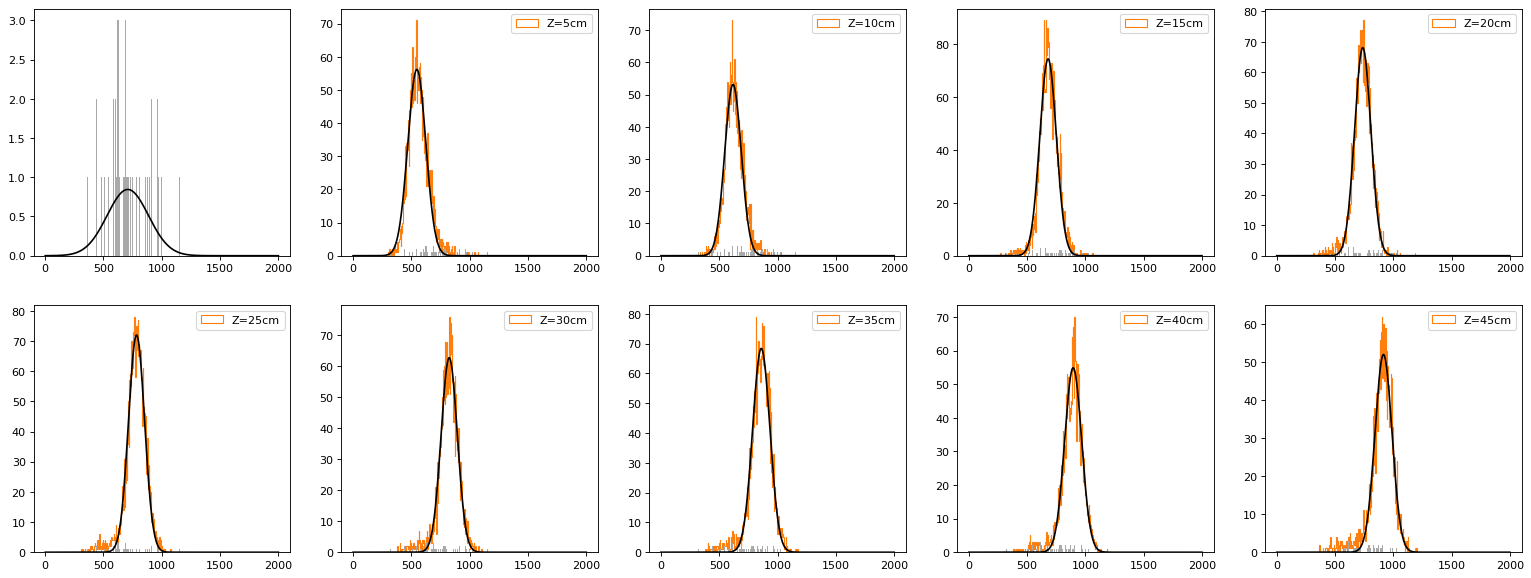

In [12]:
#@title $\sigma_T$ for $500<R\leq 600$
coi600, dcoi600 = fit_tsigma(roi.loc[(roi['R']<=600) & (roi['R']>500)], 200, 'TSigma')

'####################################################################################################'

BACKGROUND
A= 0.43+/-0.07
x0= (8.6+/-1.0)e+02
sigma= (2.8+/-1.2)e+02
RMSE =  0.6379236512179499


'####################################################################################################'

Z =  5
A = 51.5+/-0.8
x0 =  535.3+/-1.4
sigma =  79.9+/-1.4
RMSE =  3.815469581997357


'####################################################################################################'

Z =  10
A = 49.8+/-0.9
x0 =  609.0+/-1.5
sigma =  75.1+/-1.5
RMSE =  4.328590507177967


'####################################################################################################'

Z =  15
A = 79.5+/-0.9
x0 =  671.0+/-0.9
sigma =  68.8+/-0.9
RMSE =  3.683175519527677


'####################################################################################################'

Z =  20
A = 71.3+/-0.9
x0 =  726.3+/-1.0
sigma =  69.1+/-1.0
RMSE =  4.25364372188305


'####################################################################################################'

Z =  25
A = 74.7+/-1.0
x0 =  776.4+/-1.1
sigma =  73.0+/-1.1
RMSE =  4.378866827408566


'####################################################################################################'

Z =  30
A = 63.9+/-0.8
x0 =  816.2+/-1.1
sigma =  72.1+/-1.1
RMSE =  3.8675602765303485


'####################################################################################################'

Z =  35
A = 65.1+/-0.8
x0 =  852.4+/-1.1
sigma =  76.7+/-1.1
RMSE =  3.9976474140447156


'####################################################################################################'

Z =  40
A = 53.2+/-0.8
x0 =  886.6+/-1.4
sigma =  79.6+/-1.4
RMSE =  3.68952694149635


'####################################################################################################'

Z =  45
A = 47.2+/-0.7
x0 =  912.8+/-1.4
sigma =  75.5+/-1.4
RMSE =  3.4886825656431313


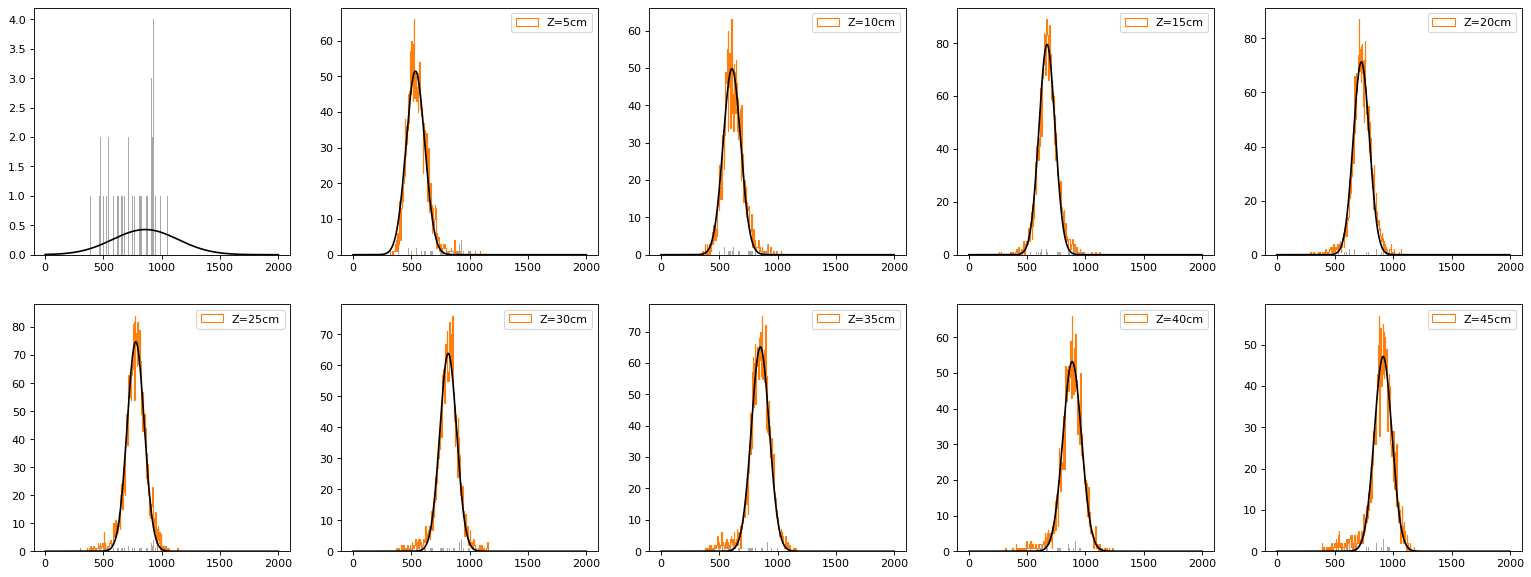

In [13]:
#@title $\sigma_T$ for $600<R\leq 700$
coi700, dcoi700 = fit_tsigma(roi.loc[(roi['R']<=700) & (roi['R']>600)], 200, 'TSigma')

'####################################################################################################'

BACKGROUND
A= 0.81+/-0.10
x0= 763+/-28
sigma= 196+/-30
RMSE =  0.7249544099236506


'####################################################################################################'

Z =  5
A = 56.8+/-1.0
x0 =  540.8+/-1.5
sigma =  75.9+/-1.5
RMSE =  4.420750298543614


'####################################################################################################'

Z =  10
A = 55.0+/-0.7
x0 =  612.2+/-1.0
sigma =  72.1+/-1.0
RMSE =  3.280563215992858


'####################################################################################################'

Z =  15
A = 76.4+/-0.9
x0 =  675.2+/-1.0
sigma =  68.3+/-1.0
RMSE =  4.051135823273659


'####################################################################################################'

Z =  20
A = 78.7+/-0.9
x0 =  731.0+/-0.9
sigma =  69.0+/-0.9
RMSE =  3.7911441201957317


'####################################################################################################'

Z =  25
A = 66.2+/-0.8
x0 =  777.1+/-0.9
sigma =  70.9+/-0.9
RMSE =  3.60497216709486


'####################################################################################################'

Z =  30
A = 67.4+/-0.9
x0 =  818.0+/-1.1
sigma =  72.9+/-1.1
RMSE =  3.9538808550967337


'####################################################################################################'

Z =  35
A = 75.4+/-1.0
x0 =  858.7+/-1.2
sigma =  76.5+/-1.2
RMSE =  4.375768861313149


'####################################################################################################'

Z =  40
A = 42.3+/-0.7
x0 =  888.9+/-1.4
sigma =  77.7+/-1.4
RMSE =  3.272440603878844


'####################################################################################################'

Z =  45
A = 45.2+/-0.7
x0 =  916.5+/-1.5
sigma =  80.8+/-1.5
RMSE =  3.5154607851467827


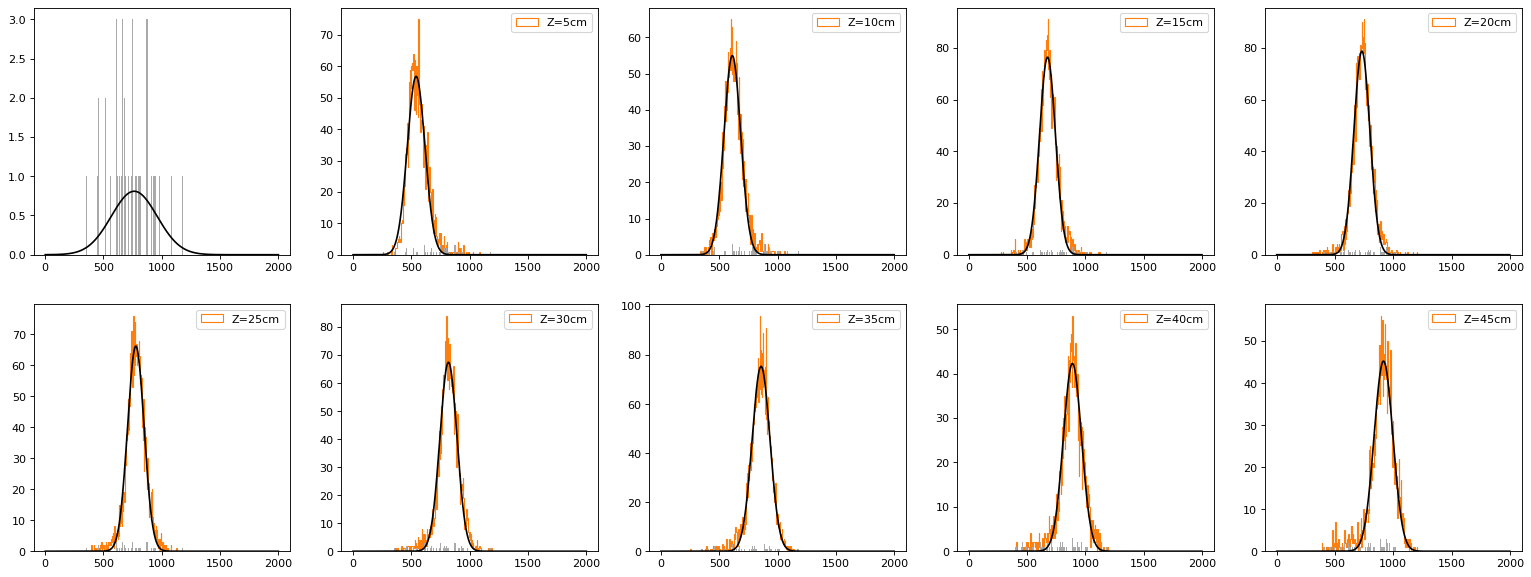

In [14]:
#@title $\sigma_T$ for $700<R\leq 800$
coi800, dcoi800 = fit_tsigma(roi.loc[(roi['R']<=800) & (roi['R']>700)], 200, 'TSigma')

'####################################################################################################'

BACKGROUND
A= 0.89+/-0.09
x0= 745+/-21
sigma= 176+/-22
RMSE =  0.6562924330214615


'####################################################################################################'

Z =  5
A = 56.1+/-0.9
x0 =  563.4+/-1.5
sigma =  76.6+/-1.5
RMSE =  4.513113604922711


'####################################################################################################'

Z =  10
A = 54.6+/-0.7
x0 =  634.0+/-1.1
sigma =  72.2+/-1.1
RMSE =  3.6521775630624678


'####################################################################################################'

Z =  15
A = 84.5+/-1.0
x0 =  695.1+/-0.9
sigma =  66.2+/-0.9
RMSE =  4.0904680001850755


'####################################################################################################'

Z =  20
A = 74.7+/-1.0
x0 =  747.1+/-1.1
sigma =  72.5+/-1.1
RMSE =  4.348368276786177


'####################################################################################################'

Z =  25
A = 69.4+/-0.9
x0 =  796.0+/-1.1
sigma =  75.1+/-1.1
RMSE =  4.004634684360914


'####################################################################################################'

Z =  30
A = 82.0+/-1.0
x0 =  835.5+/-1.0
sigma =  73.2+/-1.0
RMSE =  3.9183531356313974


'####################################################################################################'

Z =  35
A = 70.3+/-0.9
x0 =  873.9+/-1.1
sigma =  77.0+/-1.1
RMSE =  4.04225638052445


'####################################################################################################'

Z =  40
A = 53.4+/-0.7
x0 =  908.9+/-1.3
sigma =  81.1+/-1.3
RMSE =  3.365777609701586


'####################################################################################################'

Z =  45
A = 48.2+/-0.7
x0 =  928.1+/-1.4
sigma =  77.9+/-1.4
RMSE =  3.4884639249865383


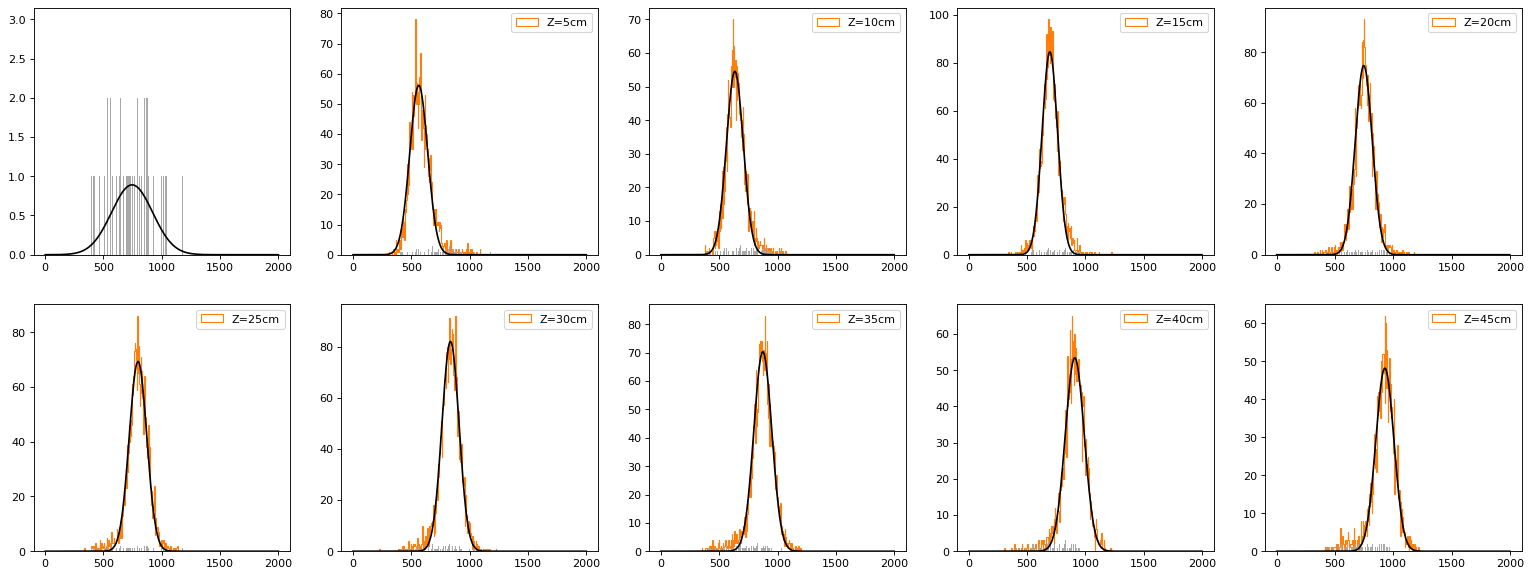

In [15]:
#@title $\sigma_T$ for $800<R\leq 900$
coi900, dcoi900 = fit_tsigma(roi.loc[(roi['R']<=900) & (roi['R']>800)], 200, 'TSigma')

'####################################################################################################'

BACKGROUND
A= 0.64+/-0.08
x0= 789+/-27
sigma= 164+/-30
RMSE =  0.633350871827424


'####################################################################################################'

Z =  5
A = 53.5+/-0.7
x0 =  589.3+/-1.2
sigma =  77.6+/-1.2
RMSE =  3.3956926138914416


'####################################################################################################'

Z =  10
A = 49.5+/-0.7
x0 =  658.6+/-1.3
sigma =  73.5+/-1.3
RMSE =  3.6035954523990132


'####################################################################################################'

Z =  15
A = 73.6+/-0.9
x0 =  716.1+/-1.0
sigma =  72.9+/-1.0
RMSE =  3.813143836071064


'####################################################################################################'

Z =  20
A = 64.9+/-0.9
x0 =  773.1+/-1.2
sigma =  73.7+/-1.2
RMSE =  4.272991799260146


'####################################################################################################'

Z =  25
A = 68.2+/-0.8
x0 =  819.9+/-1.1
sigma =  73.8+/-1.1
RMSE =  3.7870707425820798


'####################################################################################################'

Z =  30
A = 64.7+/-0.9
x0 =  856.5+/-1.1
sigma =  75.1+/-1.1
RMSE =  3.8184491158273706


'####################################################################################################'

Z =  35
A = 68.2+/-0.9
x0 =  892.6+/-1.2
sigma =  77.3+/-1.2
RMSE =  4.230561241535315


'####################################################################################################'

Z =  40
A = 41.8+/-0.7
x0 =  926.9+/-1.5
sigma =  82.1+/-1.5
RMSE =  3.173963715467875


'####################################################################################################'

Z =  45
A = 50.9+/-0.7
x0 =  947.0+/-1.4
sigma =  82.0+/-1.4
RMSE =  3.474142652573184


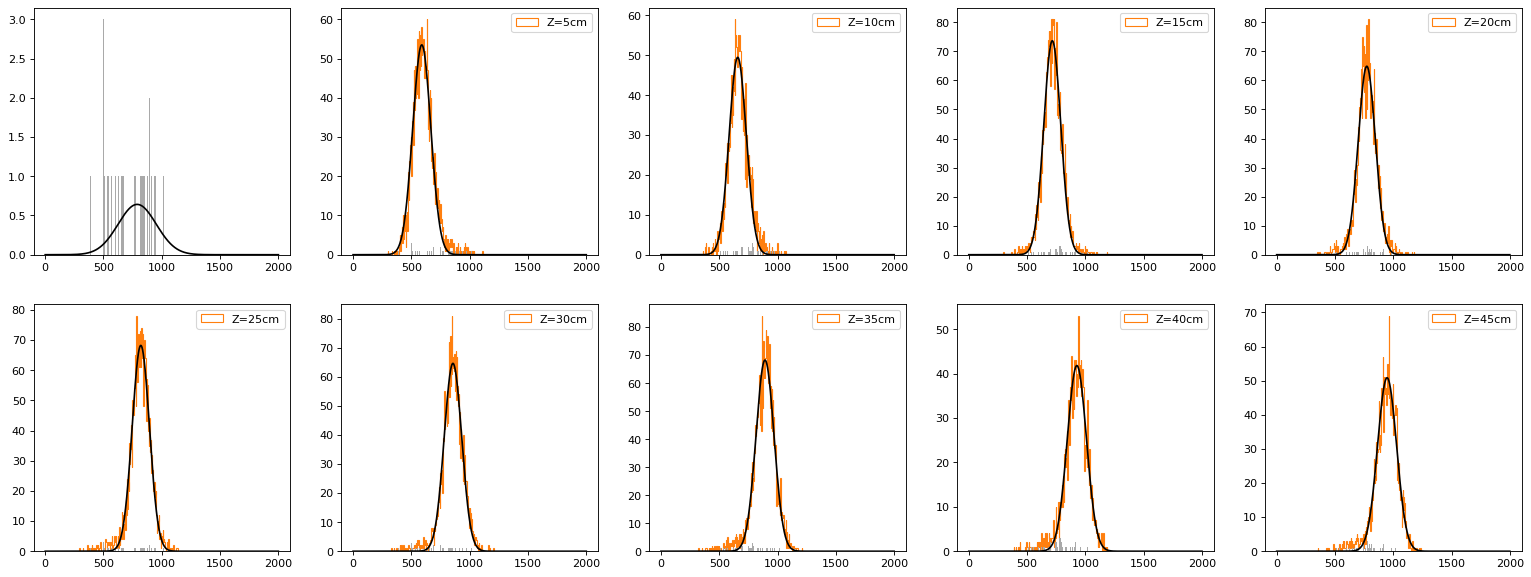

In [16]:
#@title $\sigma_T$ for $900<R\leq 1000$
coi1000, dcoi1000 = fit_tsigma(roi.loc[(roi['R']<=1000) & (roi['R']>900)], 200, 'TSigma')

'####################################################################################################'

BACKGROUND
A= 0.69+/-0.09
x0= 779+/-30
sigma= 192+/-33
RMSE =  0.6859590250810293


'####################################################################################################'

Z =  5
A = 29.4+/-0.5
x0 =  595.3+/-1.7
sigma =  84.8+/-1.7
RMSE =  2.3684297295008245


'####################################################################################################'

Z =  10
A = 28.9+/-0.6
x0 =  664.1+/-1.9
sigma =  80.9+/-1.9
RMSE =  2.743290028191579


'####################################################################################################'

Z =  15
A = 33.2+/-0.6
x0 =  720.8+/-1.6
sigma =  78.3+/-1.6
RMSE =  2.7957614215153055


'####################################################################################################'

Z =  20
A = 35.6+/-0.7
x0 =  774.9+/-1.7
sigma =  76.4+/-1.7
RMSE =  3.178915920680816


'####################################################################################################'

Z =  25
A = 37.2+/-0.7
x0 =  817.0+/-1.6
sigma =  76.4+/-1.6
RMSE =  3.0124093323587515


'####################################################################################################'

Z =  30
A = 32.0+/-0.6
x0 =  855.3+/-1.7
sigma =  77.7+/-1.7
RMSE =  2.7334405338799255


'####################################################################################################'

Z =  35
A = 35.4+/-0.7
x0 =  890.3+/-1.8
sigma =  83.4+/-1.8
RMSE =  2.990937774460027


'####################################################################################################'

Z =  40
A = 20.5+/-0.5
x0 =  918.5+/-2.6
sigma =  90.0+/-2.6
RMSE =  2.6914139190350173


'####################################################################################################'

Z =  45
A = 19.6+/-0.5
x0 =  946.0+/-2.7
sigma =  92.5+/-2.7
RMSE =  2.601017090695996


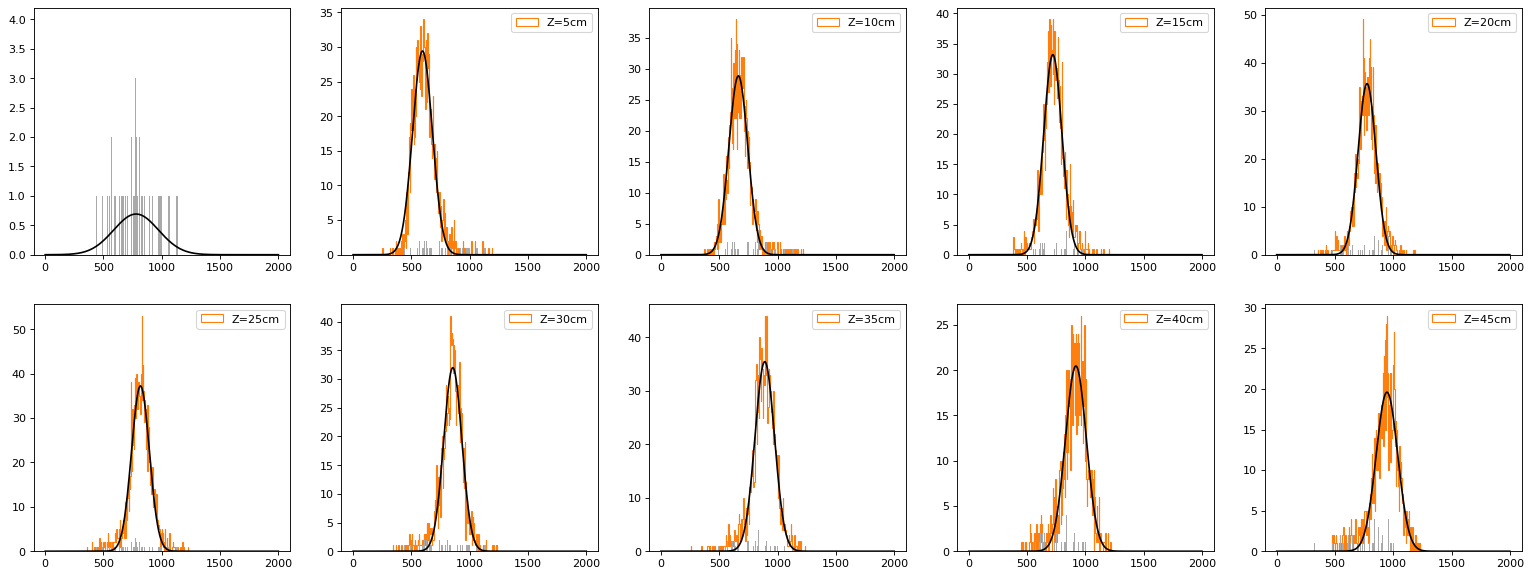

In [17]:
#@title $\sigma_T$ for $1000<R\leq 1100$
coi1100, dcoi1100 = fit_tsigma(roi.loc[(roi['R']<=1100) & (roi['R']>1000)], 200, 'TSigma')

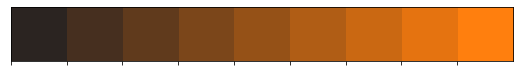

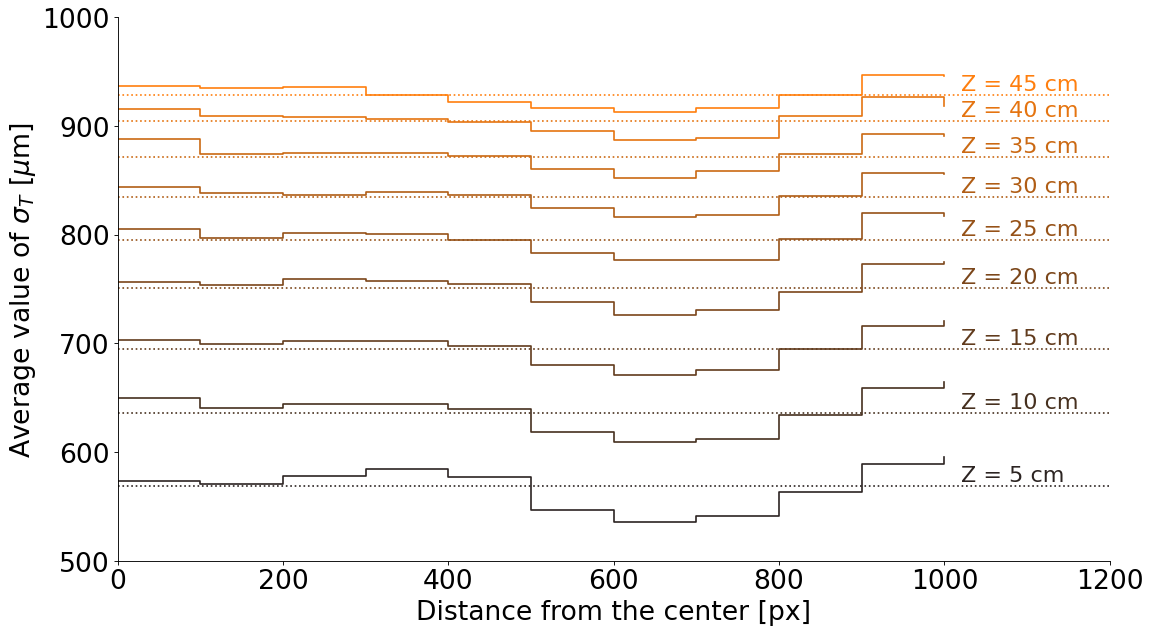

In [18]:
#@title $\sigma_T$ in function of $R$

#@markdown There is a significant difference in $\sigma_T$ for clusters further then 400 px from the center of the image

z = []
r = []
for d in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100]:
  for Z in [5, 10, 15, 20, 25, 30, 35, 40, 45]: 
    z.append(Z)
    r.append(d)
sigma = coi100+coi200+coi300+coi400+coi500+coi600+coi700+coi800+coi900+coi1000+coi1100
dsigma = dcoi100+dcoi200+dcoi300+dcoi400+dcoi500+dcoi600+dcoi700+dcoi800+dcoi900+dcoi1000+dcoi1100
sigmaT = pd.DataFrame(list(zip(z, r, sigma, dsigma)), 
                    columns =['z[cm]', 'R[px]', 'TSigma', 'dTSigma']) 

color = get_color(9, 'tab:orange')

fig, (ax) = plt.subplots(figsize=(16,9), dpi= 80, facecolor='w', edgecolor='k') 
i=0
for z in [5, 10, 15, 20, 25, 30, 35, 40, 45]:
  plt.step(sigmaT['R[px]'].loc[sigmaT['z[cm]']==z]-100, sigmaT['TSigma'].loc[sigmaT['z[cm]']==z], color=color[i], where='post')
  plt.text(1020, allcoi[i]+10, 'Z = '+str(z)+' cm', fontsize=20, color=color[i], va='center')
  plt.axhline(y=allcoi[i], color=color[i], ls=':')
  i = i+1

ax.set_xlim(0,1200)
ax.set_ylim(500,1000)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylabel('Average value of $\sigma_T$ [$\mu$m]', y=0.5, ha='center', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_xlabel('Distance from the center [px]', x=0.5, ha='center', fontsize=24)

plt.show()

# Longitudinal Diffusion

'####################################################################################################'

BACKGROUND
A= 6.53+/-0.28
x0= 990+/-13
sigma= 252+/-14
RMSE =  2.0896076605733187


'####################################################################################################'

Z =  5
A = 499+/-4
x0 =  717.1+/-1.2
sigma =  118.3+/-1.2
RMSE =  21.092653637007825


'####################################################################################################'

Z =  10
A = 525.9+/-3.4
x0 =  791.1+/-0.8
sigma =  111.9+/-0.8
RMSE =  16.203564609035514


'####################################################################################################'

Z =  15
A = 625+/-4
x0 =  861.9+/-0.8
sigma =  107.0+/-0.8
RMSE =  18.38204243072568


'####################################################################################################'

Z =  20
A = 642+/-4
x0 =  924.9+/-0.7
sigma =  105.2+/-0.7
RMSE =  18.308985314179427


'####################################################################################################'

Z =  25
A = 650+/-4
x0 =  976.6+/-0.7
sigma =  105.2+/-0.7
RMSE =  16.78269327404388


'####################################################################################################'

Z =  30
A = 581.6+/-3.4
x0 =  1022.1+/-0.7
sigma =  105.1+/-0.7
RMSE =  15.996029607783674


'####################################################################################################'

Z =  35
A = 640+/-4
x0 =  1061.7+/-0.7
sigma =  105.4+/-0.7
RMSE =  18.017289406222627


'####################################################################################################'

Z =  40
A = 448.7+/-2.7
x0 =  1095.2+/-0.7
sigma =  104.9+/-0.7
RMSE =  12.989056284132927


'####################################################################################################'

Z =  45
A = 465.4+/-3.0
x0 =  1119.9+/-0.8
sigma =  104.2+/-0.8
RMSE =  14.355543610870019


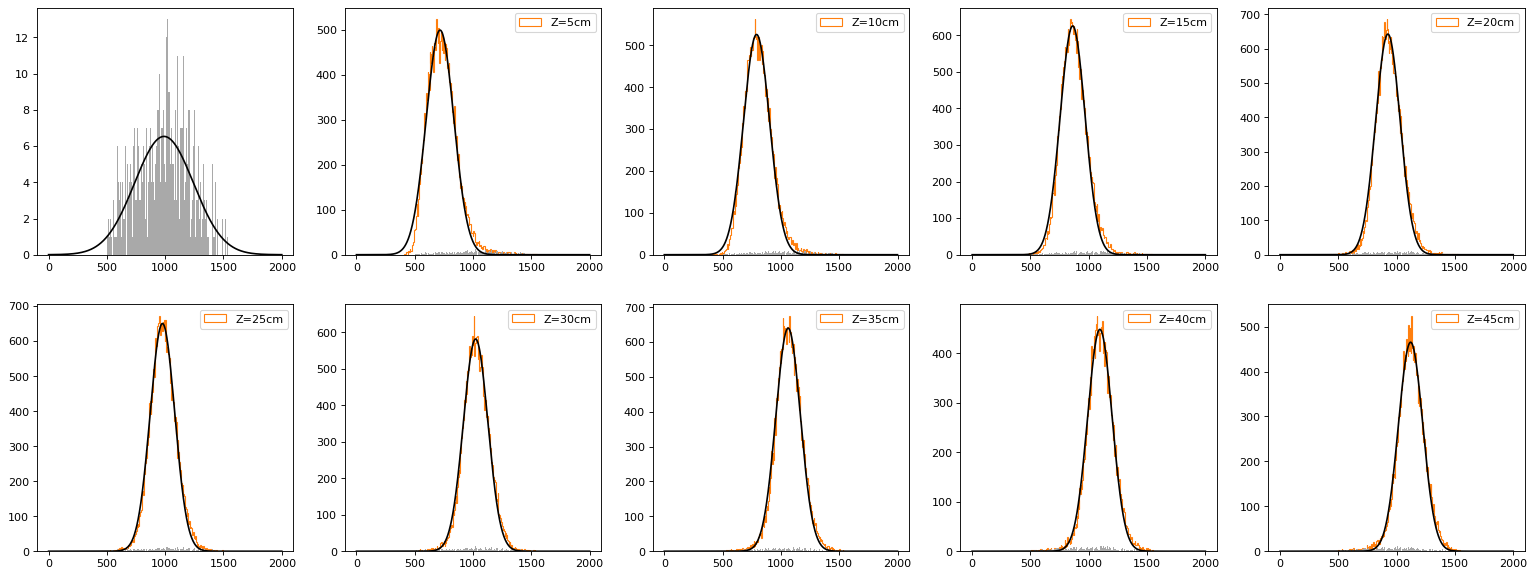

In [19]:
#@title Average $\sigma_L$ for all CoIs

Lallcoi, dLallcoi = fit_tsigma(roi, 200, 'LSigma')

## Average $\sigma_L$ for different slices

'####################################################################################################'

BACKGROUND
A= 0.73+/-0.25
x0= 833+/-17
sigma= 45+/-17
RMSE =  0.4666550908966651


'####################################################################################################'

Z =  5
A = 50.0+/-2.0
x0 =  636+/-4
sigma =  93+/-5
RMSE =  4.95687548096402


'####################################################################################################'

Z =  10
A = 43.8+/-1.1
x0 =  735.1+/-2.7
sigma =  90.3+/-2.7
RMSE =  2.974561597532434


'####################################################################################################'

Z =  15
A = 46.2+/-1.7
x0 =  814.7+/-3.4
sigma =  80.4+/-3.4
RMSE =  4.377335253184687


'####################################################################################################'

Z =  20
A = 44.5+/-1.6
x0 =  880.8+/-3.3
sigma =  80.2+/-3.3
RMSE =  4.304600166354501


'####################################################################################################'

Z =  25
A = 63.6+/-1.4
x0 =  939.8+/-2.0
sigma =  78.4+/-2.0
RMSE =  3.289726967538358


'####################################################################################################'

Z =  30
A = 48.5+/-1.7
x0 =  975.1+/-3.0
sigma =  -76.1+/-3.0
RMSE =  3.9610869547431333


'####################################################################################################'

Z =  35
A = 72.5+/-1.8
x0 =  1022.7+/-2.4
sigma =  83.9+/-2.4
RMSE =  4.033235496397329


'####################################################################################################'

Z =  40
A = 41.9+/-1.6
x0 =  1052.2+/-3.2
sigma =  75.5+/-3.2
RMSE =  3.608725588988784


'####################################################################################################'

Z =  45
A = 46.9+/-1.1
x0 =  1084.9+/-2.3
sigma =  81.2+/-2.3
RMSE =  2.828606156683922


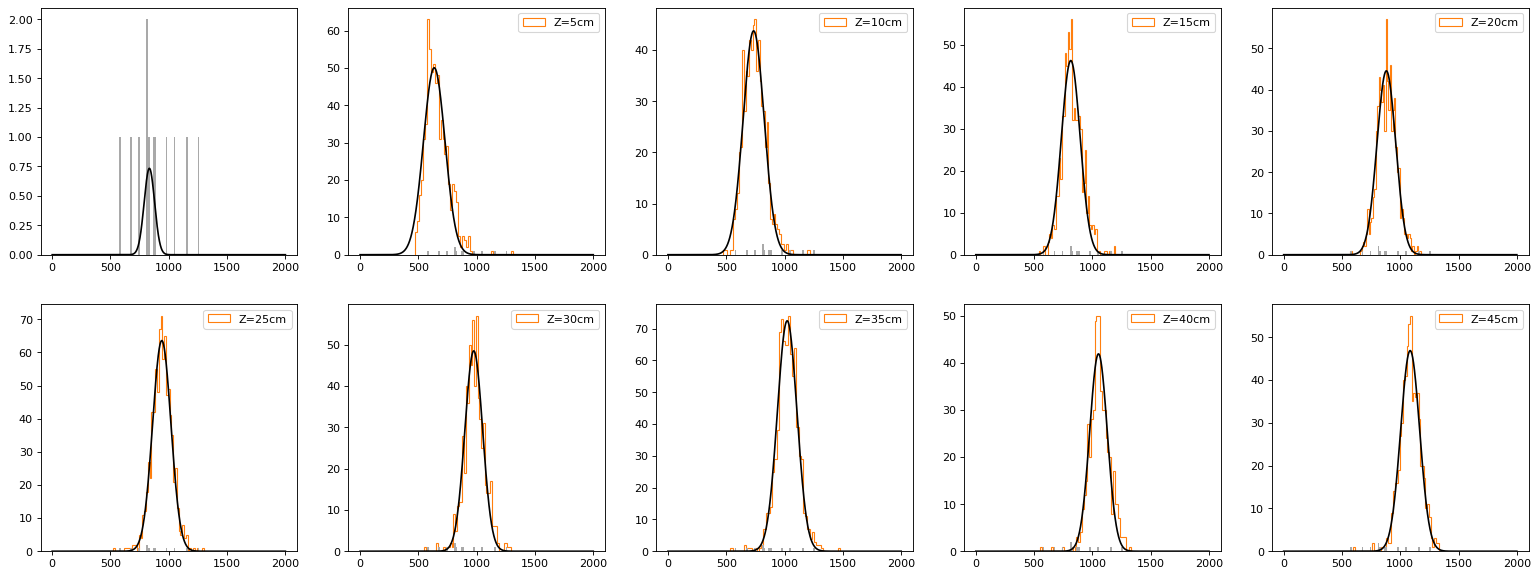

In [20]:
#@title $\sigma_L$ for $0\leq R\leq100$
Lcoi100, dLcoi100 = fit_tsigma(roi.loc[(roi['R']<=100)], 50, 'LSigma')

'####################################################################################################'

BACKGROUND
A= (0.0+/-1.2)e+03
x0= (0+/-9)e+11
sigma= (-0.0+/-1.1)e+13
RMSE =  1.140175425099138


'####################################################################################################'

Z =  5
A = 178+/-5
x0 =  635.7+/-2.5
sigma =  85.3+/-2.5
RMSE =  9.825175386719922


'####################################################################################################'

Z =  10
A = 175.5+/-3.1
x0 =  724.9+/-1.7
sigma =  85.5+/-1.7
RMSE =  6.679947053691557


'####################################################################################################'

Z =  15
A = 174.5+/-2.3
x0 =  804.8+/-1.3
sigma =  -82.8+/-1.3
RMSE =  5.296389338600542


'####################################################################################################'

Z =  20
A = 205.5+/-2.6
x0 =  874.7+/-1.1
sigma =  76.2+/-1.1
RMSE =  5.6564106643249215


'####################################################################################################'

Z =  25
A = 216.6+/-3.2
x0 =  926.8+/-1.3
sigma =  79.4+/-1.3
RMSE =  6.893118667174991


'####################################################################################################'

Z =  30
A = 158.5+/-2.5
x0 =  974.9+/-1.4
sigma =  -80.4+/-1.4
RMSE =  5.845758973073399


'####################################################################################################'

Z =  35
A = 202.4+/-3.1
x0 =  1014.8+/-1.4
sigma =  -78.9+/-1.4
RMSE =  6.7305219654350745


'####################################################################################################'

Z =  40
A = 123.2+/-2.6
x0 =  1050.9+/-2.1
sigma =  87.4+/-2.1
RMSE =  6.078932054794223


'####################################################################################################'

Z =  45
A = 167.5+/-3.3
x0 =  1083.3+/-1.9
sigma =  84.9+/-1.9
RMSE =  7.255266218834662


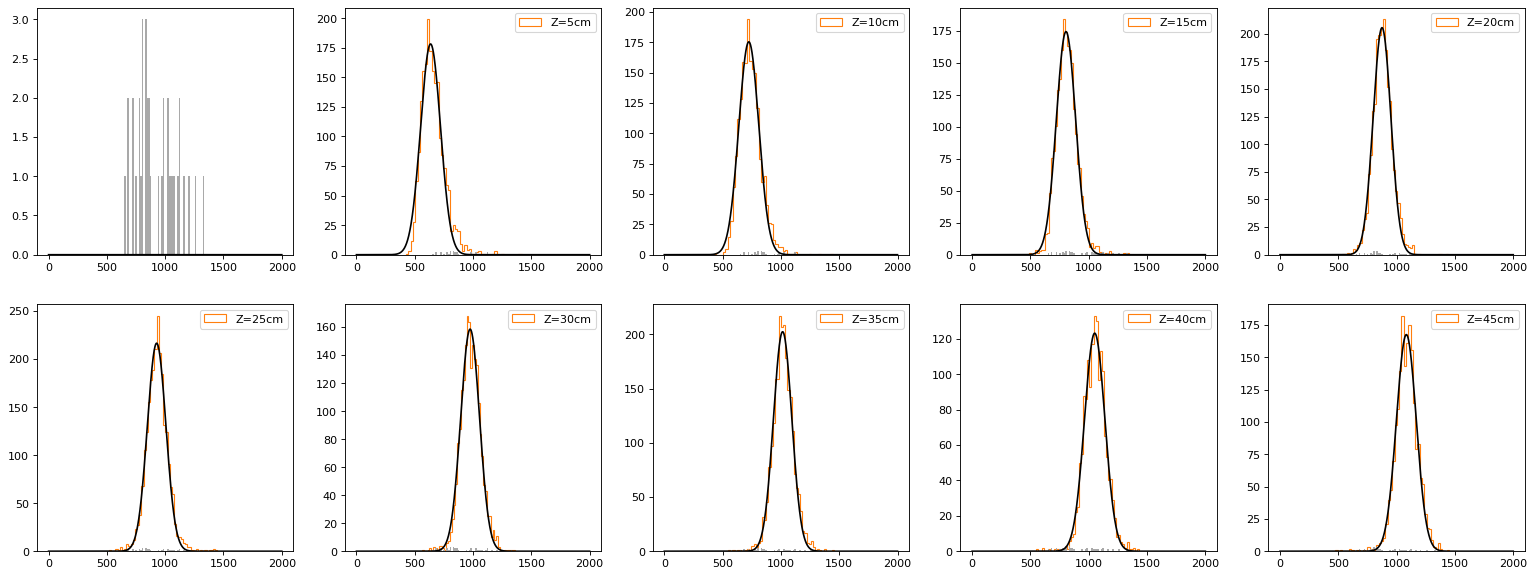

In [21]:
#@title $\sigma_L$ for $100<R\leq 200$
Lcoi200, dLcoi200 = fit_tsigma(roi.loc[(roi['R']<=200) & (roi['R']>100)], 50, 'LSigma')

'####################################################################################################'

BACKGROUND
A= 7.0+/-1.4
x0= 949+/-5
sigma= 9.4+/-2.4
RMSE =  1.3636839170377144


'####################################################################################################'

Z =  5
A = 205+/-5
x0 =  643.8+/-2.4
sigma =  84.3+/-2.4
RMSE =  12.250588775634489


'####################################################################################################'

Z =  10
A = 258+/-5
x0 =  732.4+/-1.7
sigma =  85.4+/-1.7
RMSE =  9.703455977062184


'####################################################################################################'

Z =  15
A = 290+/-5
x0 =  807.6+/-1.5
sigma =  80.9+/-1.5
RMSE =  9.933705556455333


'####################################################################################################'

Z =  20
A = 307+/-4
x0 =  874.9+/-1.1
sigma =  78.8+/-1.1
RMSE =  7.854441085277638


'####################################################################################################'

Z =  25
A = 279.2+/-2.8
x0 =  929.7+/-0.9
sigma =  79.5+/-0.9
RMSE =  6.287597569948411


'####################################################################################################'

Z =  30
A = 219.7+/-2.8
x0 =  975.7+/-1.2
sigma =  79.9+/-1.2
RMSE =  6.830770065280766


'####################################################################################################'

Z =  35
A = 284+/-4
x0 =  1015.3+/-1.4
sigma =  83.4+/-1.4
RMSE =  9.062556912447247


'####################################################################################################'

Z =  40
A = 213.6+/-2.7
x0 =  1049.5+/-1.2
sigma =  85.5+/-1.2
RMSE =  5.709114201695583


'####################################################################################################'

Z =  45
A = 248.5+/-2.8
x0 =  1081.3+/-1.1
sigma =  -84.0+/-1.1
RMSE =  6.027337227363632


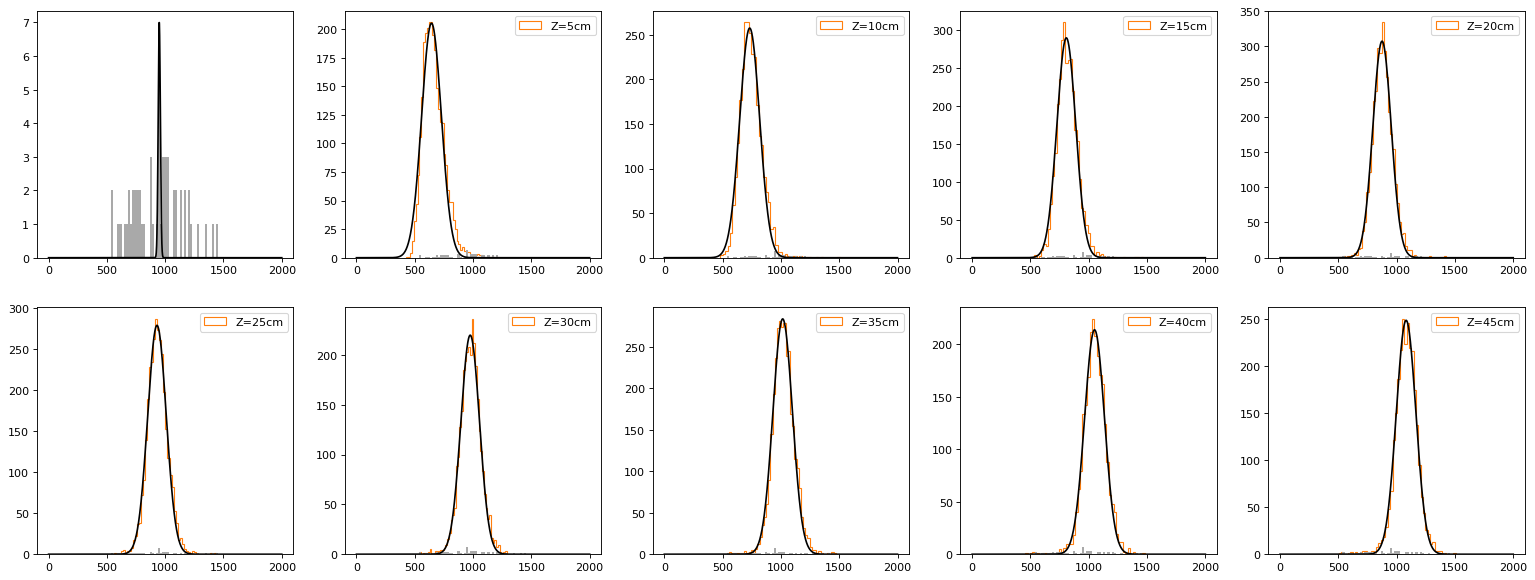

In [22]:
#@title $\sigma_L$ for $200<R\leq 300$
Lcoi300, dLcoi300 = fit_tsigma(roi.loc[(roi['R']<=300) & (roi['R']>200)], 50, 'LSigma')

'####################################################################################################'

BACKGROUND
A= 0.28+/-0.05
x0= (8.5+/-2.6)e+02
sigma= (6+/-5)e+02
RMSE =  0.5066517970055792


'####################################################################################################'

Z =  5
A = 71.5+/-1.3
x0 =  651.6+/-1.7
sigma =  84.8+/-1.7
RMSE =  5.320789573442083


'####################################################################################################'

Z =  10
A = 45.3+/-0.7
x0 =  735.6+/-1.6
sigma =  89.3+/-1.6
RMSE =  3.762561846601667


'####################################################################################################'

Z =  15
A = 72.8+/-0.9
x0 =  817.4+/-1.2
sigma =  82.6+/-1.2
RMSE =  4.284539871985964


'####################################################################################################'

Z =  20
A = 74.5+/-0.9
x0 =  886.6+/-1.2
sigma =  82.4+/-1.2
RMSE =  4.113995955009889


'####################################################################################################'

Z =  25
A = 72.1+/-0.9
x0 =  934.5+/-1.2
sigma =  85.1+/-1.2
RMSE =  4.152298490541471


'####################################################################################################'

Z =  30
A = 66.7+/-0.8
x0 =  983.6+/-1.1
sigma =  81.8+/-1.1
RMSE =  3.678493164865056


'####################################################################################################'

Z =  35
A = 73.9+/-0.9
x0 =  1021.8+/-1.2
sigma =  82.7+/-1.2
RMSE =  4.0383629283505


'####################################################################################################'

Z =  40
A = 53.7+/-0.8
x0 =  1054.9+/-1.5
sigma =  83.0+/-1.5
RMSE =  3.582153688969249


'####################################################################################################'

Z =  45
A = 57.1+/-0.7
x0 =  1082.7+/-1.3
sigma =  83.1+/-1.3
RMSE =  3.243503668609389


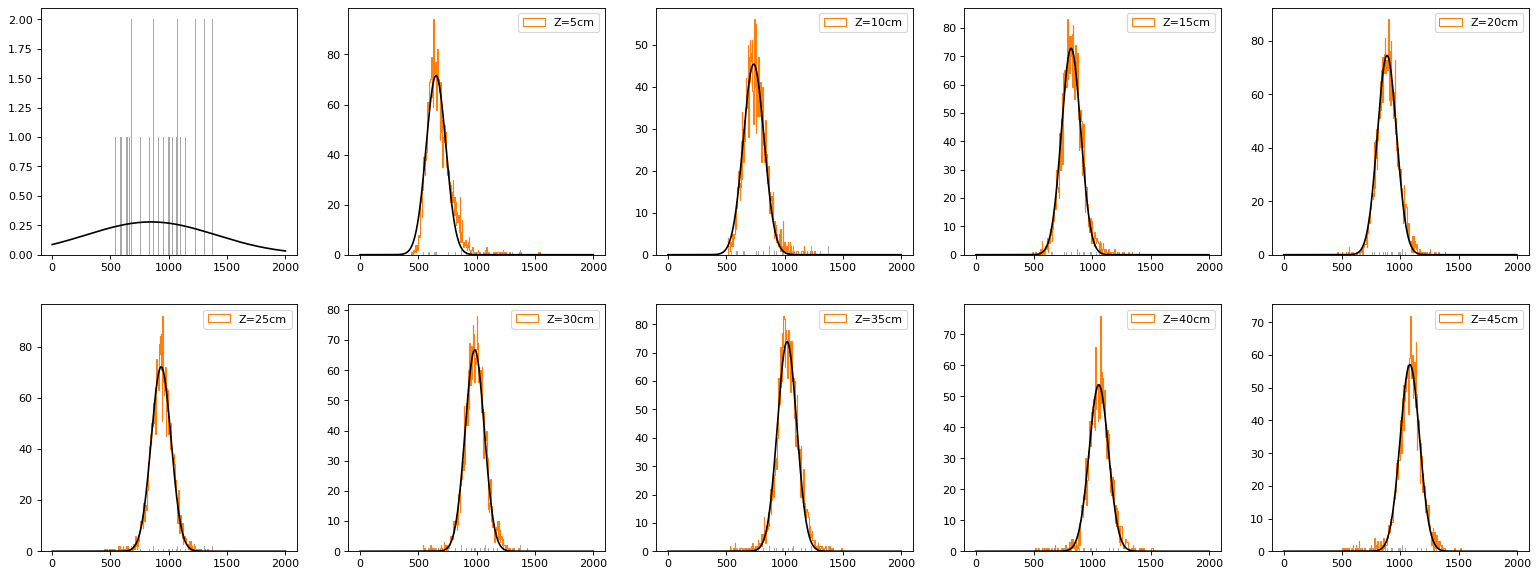

In [23]:
#@title $\sigma_L$ for $300<R\leq 400$
Lcoi400, dLcoi400 = fit_tsigma(roi.loc[(roi['R']<=400) & (roi['R']>300)], 200, 'LSigma')

'####################################################################################################'

BACKGROUND
A= 0.59+/-0.08
x0= (8.3+/-0.9)e+02
sigma= (-3.7+/-1.2)e+02
RMSE =  0.7171200386150264


'####################################################################################################'

Z =  5
A = 63.8+/-1.1
x0 =  679.3+/-1.8
sigma =  91.1+/-1.8
RMSE =  4.90035124449351


'####################################################################################################'

Z =  10
A = 63.4+/-0.8
x0 =  752.1+/-1.3
sigma =  90.7+/-1.4
RMSE =  3.7615025631601786


'####################################################################################################'

Z =  15
A = 75.2+/-1.1
x0 =  826.8+/-1.4
sigma =  88.8+/-1.4
RMSE =  4.815273719347938


'####################################################################################################'

Z =  20
A = 68.4+/-0.8
x0 =  891.2+/-1.1
sigma =  85.6+/-1.1
RMSE =  3.666364345200156


'####################################################################################################'

Z =  25
A = 65.6+/-0.9
x0 =  944.0+/-1.3
sigma =  82.7+/-1.3
RMSE =  4.197084463216592


'####################################################################################################'

Z =  30
A = 75.1+/-0.9
x0 =  986.6+/-1.1
sigma =  83.5+/-1.1
RMSE =  3.768647056692814


'####################################################################################################'

Z =  35
A = 71.6+/-0.8
x0 =  1029.0+/-1.1
sigma =  84.9+/-1.1
RMSE =  3.8184371794803074


'####################################################################################################'

Z =  40
A = 49.0+/-0.8
x0 =  1063.7+/-1.6
sigma =  84.9+/-1.6
RMSE =  3.6483439390706778


'####################################################################################################'

Z =  45
A = 51.4+/-0.8
x0 =  1086.8+/-1.5
sigma =  85.5+/-1.5
RMSE =  3.5138667325790673


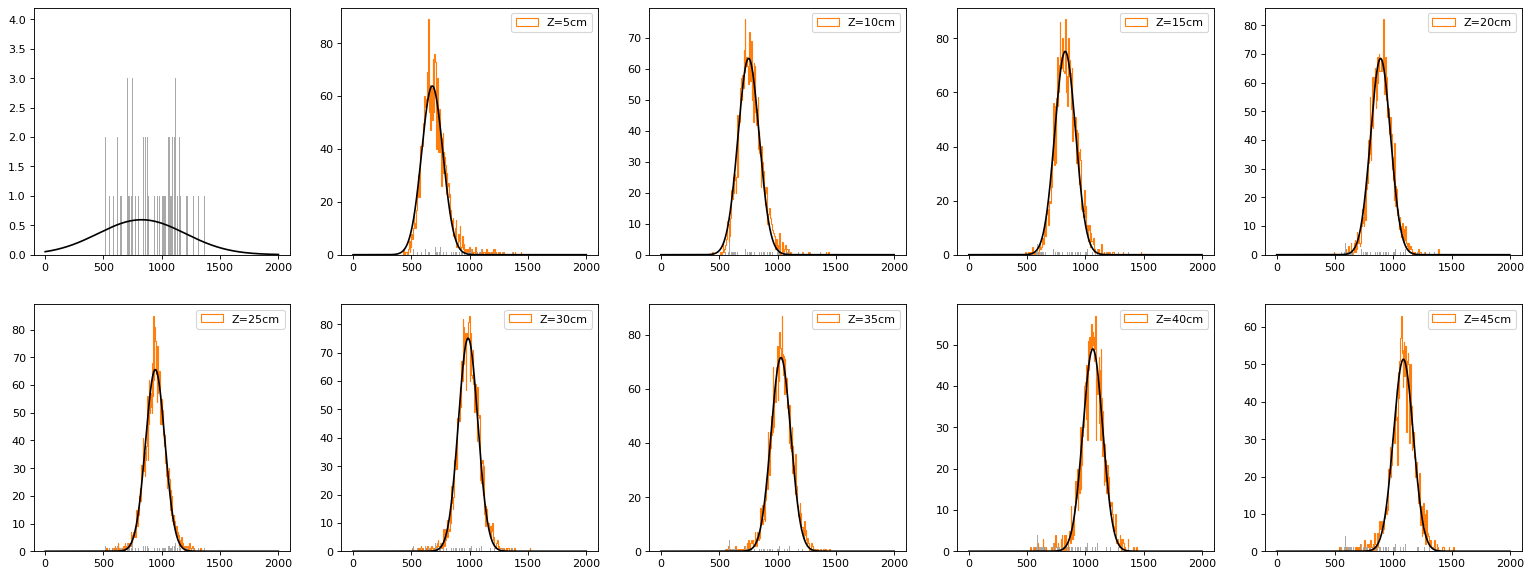

In [24]:
#@title $\sigma_L$ for $400<R\leq 500$
Lcoi500, dLcoi500 = fit_tsigma(roi.loc[(roi['R']<=500) & (roi['R']>400)], 200, 'LSigma')

'####################################################################################################'

BACKGROUND
A= 0.73+/-0.09
x0= 954+/-30
sigma= 214+/-32
RMSE =  0.6456935167145418


'####################################################################################################'

Z =  5
A = 64.0+/-0.8
x0 =  720.2+/-1.3
sigma =  86.9+/-1.3
RMSE =  3.703024120324269


'####################################################################################################'

Z =  10
A = 62.1+/-0.8
x0 =  789.8+/-1.4
sigma =  87.9+/-1.4
RMSE =  3.765096454147372


'####################################################################################################'

Z =  15
A = 71.6+/-0.7
x0 =  858.1+/-1.0
sigma =  89.1+/-1.0
RMSE =  3.321087189628058


'####################################################################################################'

Z =  20
A = 69.1+/-0.9
x0 =  924.9+/-1.3
sigma =  89.6+/-1.3
RMSE =  4.1852511544432


'####################################################################################################'

Z =  25
A = 80.8+/-1.0
x0 =  970.0+/-1.2
sigma =  85.1+/-1.2
RMSE =  4.358477652577515


'####################################################################################################'

Z =  30
A = 68.5+/-0.9
x0 =  1014.9+/-1.3
sigma =  89.6+/-1.3
RMSE =  3.929424220169277


'####################################################################################################'

Z =  35
A = 68.4+/-0.7
x0 =  1054.2+/-1.1
sigma =  90.4+/-1.1
RMSE =  3.4907844894824733


'####################################################################################################'

Z =  40
A = 50.4+/-0.8
x0 =  1085.2+/-1.7
sigma =  89.4+/-1.7
RMSE =  3.7742904515717934


'####################################################################################################'

Z =  45
A = 49.8+/-0.7
x0 =  1108.6+/-1.4
sigma =  88.6+/-1.4
RMSE =  3.1358940599145875


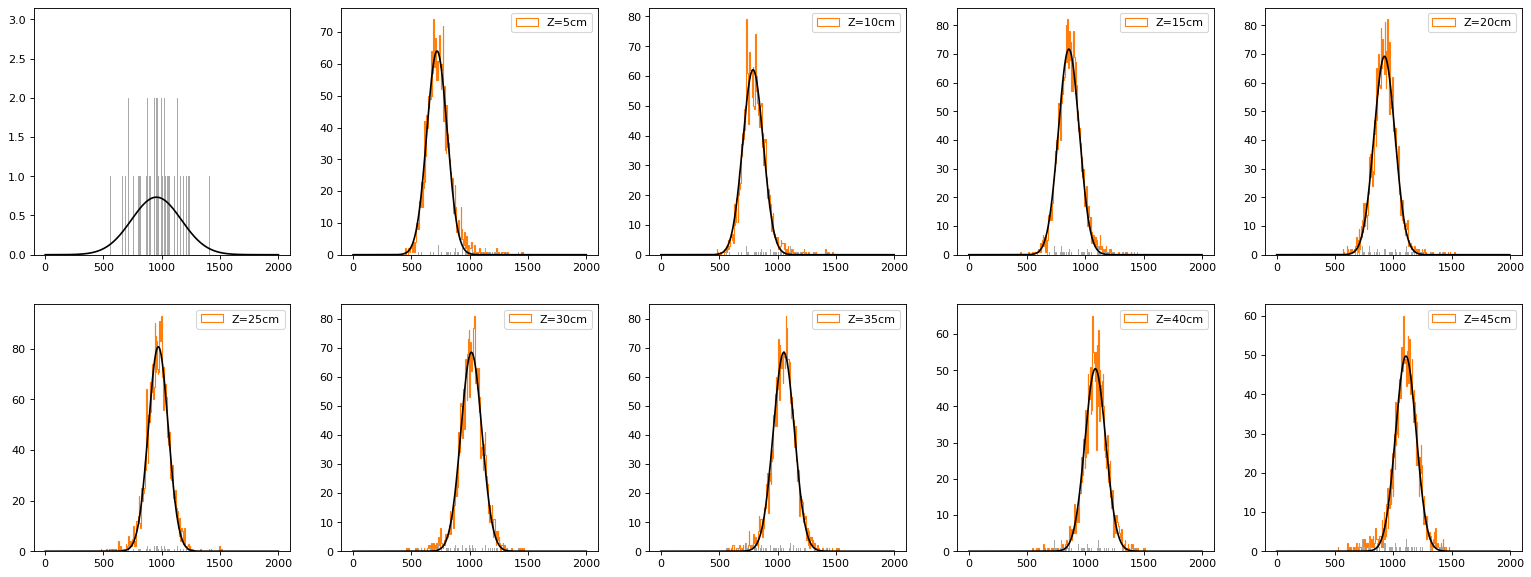

In [25]:
#@title $\sigma_L$ for $500<R\leq 600$
Lcoi600, dLcoi600 = fit_tsigma(roi.loc[(roi['R']<=600) & (roi['R']>500)], 200, 'LSigma')

'####################################################################################################'

BACKGROUND
A= 0.58+/-0.08
x0= 1092+/-32
sigma= 190+/-33
RMSE =  0.5820994058383188


'####################################################################################################'

Z =  5
A = 66.4+/-1.0
x0 =  780.6+/-1.5
sigma =  86.6+/-1.5
RMSE =  4.232896369144165


'####################################################################################################'

Z =  10
A = 56.2+/-0.9
x0 =  840.0+/-1.6
sigma =  89.7+/-1.6
RMSE =  4.061353563675464


'####################################################################################################'

Z =  15
A = 67.3+/-0.9
x0 =  906.6+/-1.5
sigma =  94.2+/-1.5
RMSE =  4.448538924427238


'####################################################################################################'

Z =  20
A = 69.5+/-0.8
x0 =  969.5+/-1.2
sigma =  92.3+/-1.2
RMSE =  3.6612215365537204


'####################################################################################################'

Z =  25
A = 61.1+/-0.8
x0 =  1018.3+/-1.5
sigma =  93.9+/-1.5
RMSE =  4.2309963898178164


'####################################################################################################'

Z =  30
A = 64.5+/-0.9
x0 =  1062.5+/-1.4
sigma =  90.8+/-1.4
RMSE =  4.001490563635218


'####################################################################################################'

Z =  35
A = 68.3+/-1.0
x0 =  1092.9+/-1.6
sigma =  95.9+/-1.6
RMSE =  4.657233648657338


'####################################################################################################'

Z =  40
A = 43.8+/-0.7
x0 =  1127.6+/-1.7
sigma =  95.1+/-1.7
RMSE =  3.2804468680656904


'####################################################################################################'

Z =  45
A = 47.9+/-0.7
x0 =  1146.6+/-1.6
sigma =  96.3+/-1.6
RMSE =  3.3072990123576838


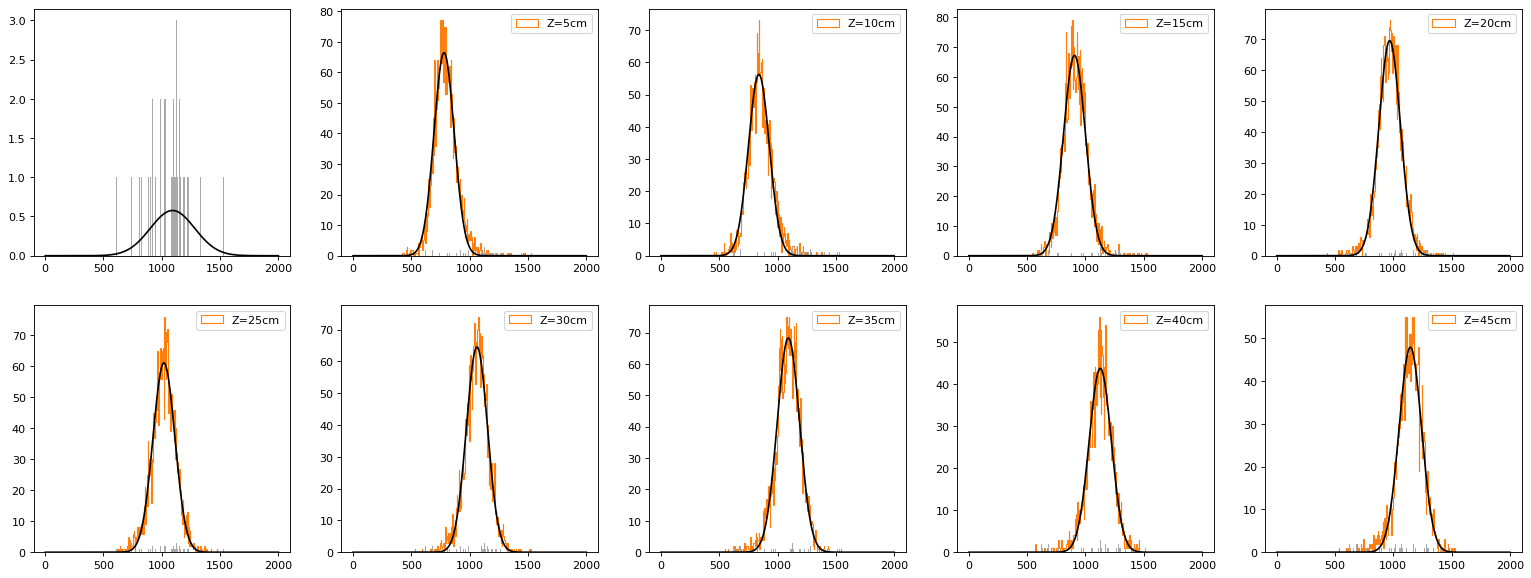

In [26]:
#@title $\sigma_L$ for $600<R\leq 700$
Lcoi700, dLcoi700 = fit_tsigma(roi.loc[(roi['R']<=700) & (roi['R']>600)], 200, 'LSigma')

'####################################################################################################'

BACKGROUND
A= 0.86+/-0.09
x0= 1039+/-25
sigma= 207+/-26
RMSE =  0.6334805165863663


'####################################################################################################'

Z =  5
A = 58.9+/-1.0
x0 =  818.8+/-1.7
sigma =  89.8+/-1.7
RMSE =  4.3700103274358675


'####################################################################################################'

Z =  10
A = 55.9+/-0.8
x0 =  876.5+/-1.5
sigma =  91.2+/-1.5
RMSE =  3.8434076679151197


'####################################################################################################'

Z =  15
A = 68.5+/-0.8
x0 =  946.1+/-1.3
sigma =  96.4+/-1.3
RMSE =  3.71788970546396


'####################################################################################################'

Z =  20
A = 62.7+/-0.8
x0 =  1003.9+/-1.4
sigma =  97.8+/-1.4
RMSE =  3.6447914412177527


'####################################################################################################'

Z =  25
A = 65.0+/-0.8
x0 =  1057.5+/-1.3
sigma =  97.1+/-1.3
RMSE =  3.696395208034381


'####################################################################################################'

Z =  30
A = 63.1+/-0.8
x0 =  1096.1+/-1.4
sigma =  93.0+/-1.4
RMSE =  3.8499839593713743


'####################################################################################################'

Z =  35
A = 61.4+/-0.9
x0 =  1133.8+/-1.6
sigma =  95.5+/-1.6
RMSE =  4.3570146484254355


'####################################################################################################'

Z =  40
A = 38.0+/-0.8
x0 =  1164.3+/-2.3
sigma =  96.0+/-2.3
RMSE =  4.102469354840969


'####################################################################################################'

Z =  45
A = 44.2+/-0.7
x0 =  1186.6+/-1.7
sigma =  99.6+/-1.7
RMSE =  3.2242804919366597


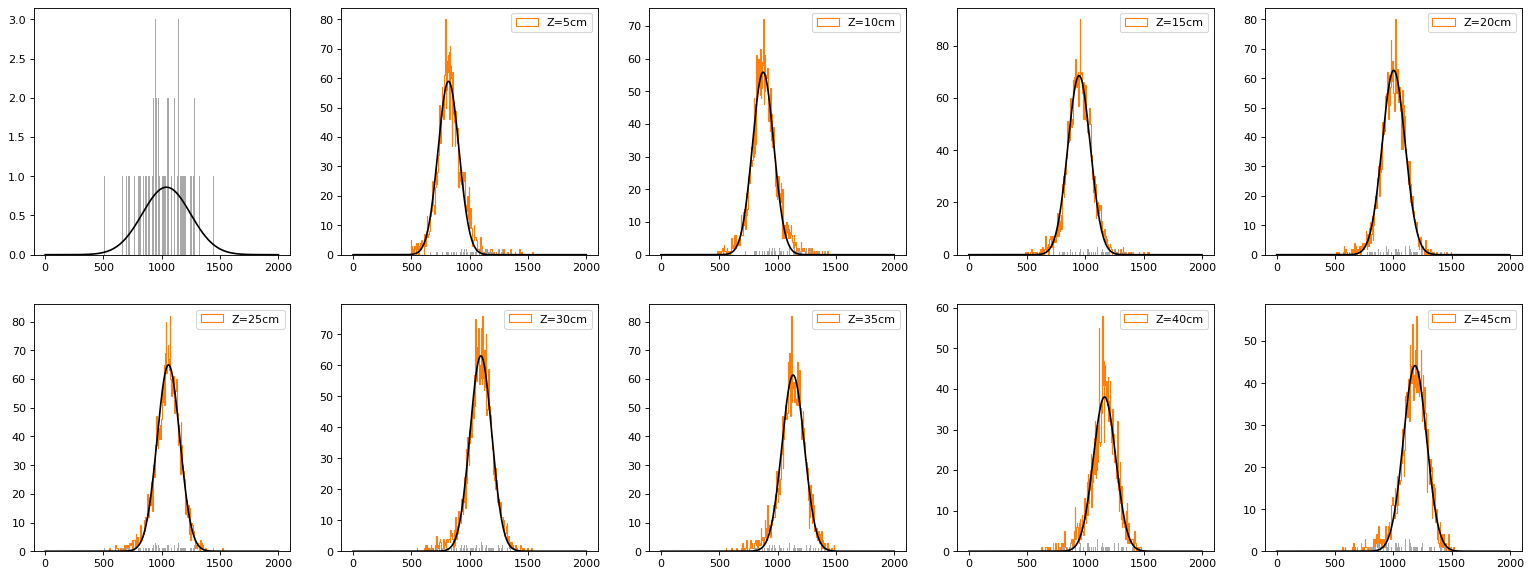

In [27]:
#@title $\sigma_L$ for $700<R\leq 800$
Lcoi800, dLcoi800 = fit_tsigma(roi.loc[(roi['R']<=800) & (roi['R']>700)], 200, 'LSigma')

'####################################################################################################'

BACKGROUND
A= 0.79+/-0.09
x0= 1026+/-34
sigma= (2.5+/-0.4)e+02
RMSE =  0.7022336160104946


'####################################################################################################'

Z =  5
A = 57.3+/-0.8
x0 =  791.3+/-1.8
sigma =  103.6+/-1.8
RMSE =  3.942742925641374


'####################################################################################################'

Z =  10
A = 59.3+/-0.8
x0 =  861.5+/-1.6
sigma =  103.6+/-1.6
RMSE =  3.7165803690454178


'####################################################################################################'

Z =  15
A = 60.0+/-0.8
x0 =  929.4+/-1.5
sigma =  104.5+/-1.5
RMSE =  3.7983966914014546


'####################################################################################################'

Z =  20
A = 57.2+/-0.8
x0 =  989.0+/-1.8
sigma =  104.7+/-1.8
RMSE =  4.2407632027519195


'####################################################################################################'

Z =  25
A = 68.0+/-0.9
x0 =  1047.7+/-1.5
sigma =  101.7+/-1.5
RMSE =  4.069648339425303


'####################################################################################################'

Z =  30
A = 60.5+/-0.8
x0 =  1085.6+/-1.6
sigma =  101.7+/-1.6
RMSE =  4.094541905593783


'####################################################################################################'

Z =  35
A = 64.1+/-1.0
x0 =  1128.4+/-1.8
sigma =  101.7+/-1.8
RMSE =  4.697251259740276


'####################################################################################################'

Z =  40
A = 41.1+/-0.6
x0 =  1150.7+/-1.8
sigma =  101.4+/-1.8
RMSE =  3.347814221875639


'####################################################################################################'

Z =  45
A = 44.1+/-0.7
x0 =  1184.1+/-2.0
sigma =  103.3+/-2.0
RMSE =  3.643565146536279


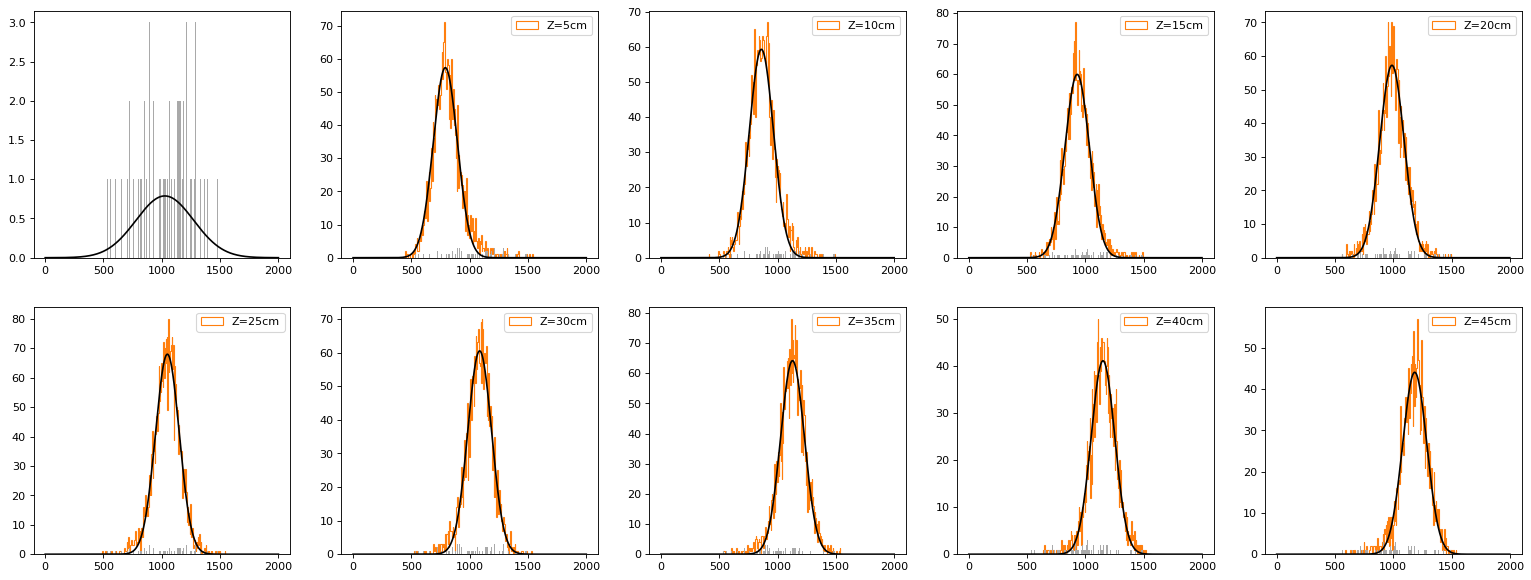

In [28]:
#@title $\sigma_L$ for $800<R\leq 900$
Lcoi900, dLcoi900 = fit_tsigma(roi.loc[(roi['R']<=900) & (roi['R']>800)], 200, 'LSigma')

'####################################################################################################'

BACKGROUND
A= 0.71+/-0.09
x0= 1081+/-32
sigma= 223+/-34
RMSE =  0.6305864156898637


'####################################################################################################'

Z =  5
A = 50.8+/-0.8
x0 =  755.6+/-1.9
sigma =  108.3+/-1.9
RMSE =  3.787619551142383


'####################################################################################################'

Z =  10
A = 47.1+/-0.7
x0 =  831.3+/-2.0
sigma =  114.1+/-2.0
RMSE =  3.6122706893599


'####################################################################################################'

Z =  15
A = 60.7+/-0.8
x0 =  907.0+/-1.6
sigma =  104.1+/-1.6
RMSE =  3.902245537329584


'####################################################################################################'

Z =  20
A = 56.6+/-0.7
x0 =  975.8+/-1.5
sigma =  109.5+/-1.5
RMSE =  3.371069261350884


'####################################################################################################'

Z =  25
A = 57.7+/-0.9
x0 =  1028.2+/-1.9
sigma =  105.9+/-1.9
RMSE =  4.3379191234266585


'####################################################################################################'

Z =  30
A = 47.8+/-0.7
x0 =  1076.3+/-1.8
sigma =  112.1+/-1.8
RMSE =  3.4406073200523024


'####################################################################################################'

Z =  35
A = 54.3+/-0.7
x0 =  1116.7+/-1.6
sigma =  104.9+/-1.6
RMSE =  3.6412475385028413


'####################################################################################################'

Z =  40
A = 41.3+/-0.7
x0 =  1146.7+/-2.0
sigma =  108.8+/-2.0
RMSE =  3.22968503606409


'####################################################################################################'

Z =  45
A = 38.9+/-0.6
x0 =  1174.4+/-1.9
sigma =  108.6+/-1.9
RMSE =  3.1144123672074278


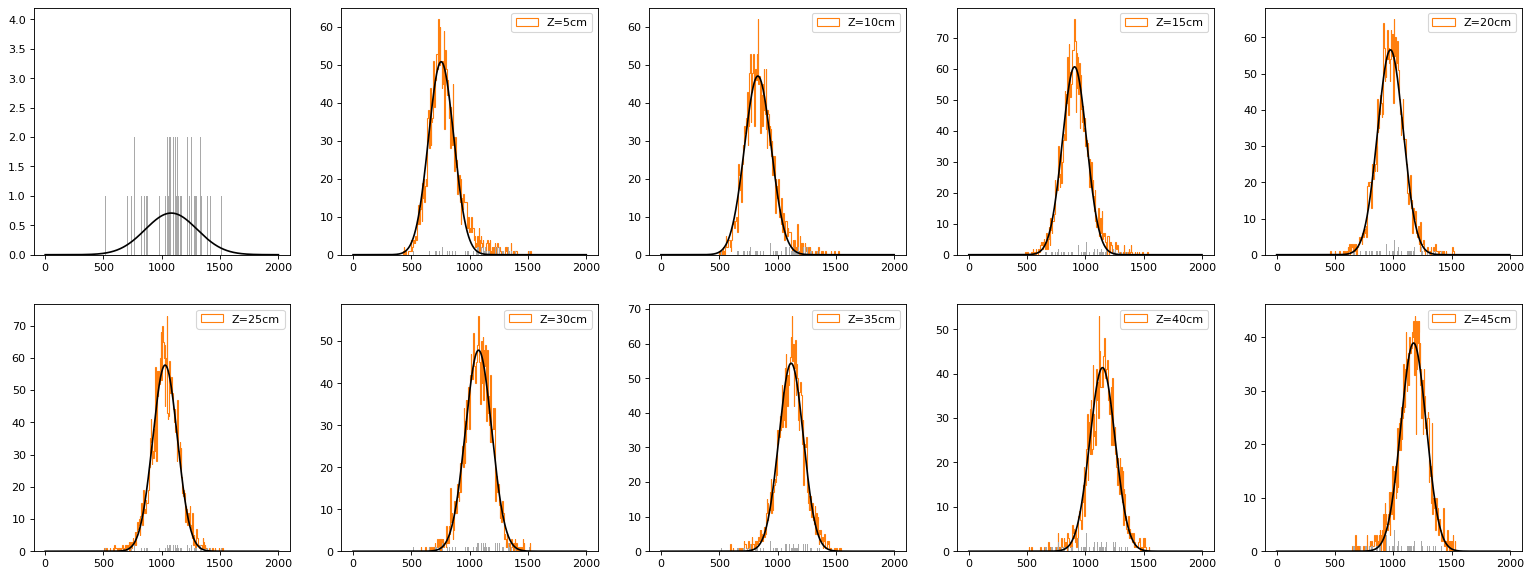

In [29]:
#@title $\sigma_L$ for $900<R\leq 1000$
Lcoi1000, dLcoi1000 = fit_tsigma(roi.loc[(roi['R']<=1000) & (roi['R']>900)], 200, 'LSigma')

'####################################################################################################'

BACKGROUND
A= 0.51+/-0.08
x0= (1.02+/-0.07)e+03
sigma= (3.7+/-1.0)e+02
RMSE =  0.6316216060604115


'####################################################################################################'

Z =  5
A = 26.0+/-0.5
x0 =  686.9+/-2.6
sigma =  111.1+/-2.6
RMSE =  2.57522648109113


'####################################################################################################'

Z =  10
A = 28.3+/-0.5
x0 =  771.3+/-2.2
sigma =  108.9+/-2.2
RMSE =  2.313518097534245


'####################################################################################################'

Z =  15
A = 31.2+/-0.5
x0 =  847.7+/-2.0
sigma =  107.9+/-2.0
RMSE =  2.4961447226758295


'####################################################################################################'

Z =  20
A = 29.9+/-0.4
x0 =  915.5+/-2.0
sigma =  118.2+/-2.0
RMSE =  2.2559484220691943


'####################################################################################################'

Z =  25
A = 27.7+/-0.5
x0 =  969.2+/-2.4
sigma =  116.6+/-2.4
RMSE =  2.664039448544944


'####################################################################################################'

Z =  30
A = 24.3+/-0.5
x0 =  1018.3+/-2.7
sigma =  120.7+/-2.7
RMSE =  2.499975124065764


'####################################################################################################'

Z =  35
A = 29.6+/-0.4
x0 =  1057.0+/-2.0
sigma =  114.3+/-2.0
RMSE =  2.2053515259310283


'####################################################################################################'

Z =  40
A = 21.8+/-0.5
x0 =  1105.0+/-3.1
sigma =  122.1+/-3.1
RMSE =  2.4371288379125358


'####################################################################################################'

Z =  45
A = 18.4+/-0.5
x0 =  1132+/-4
sigma =  129+/-4
RMSE =  2.569665347400305


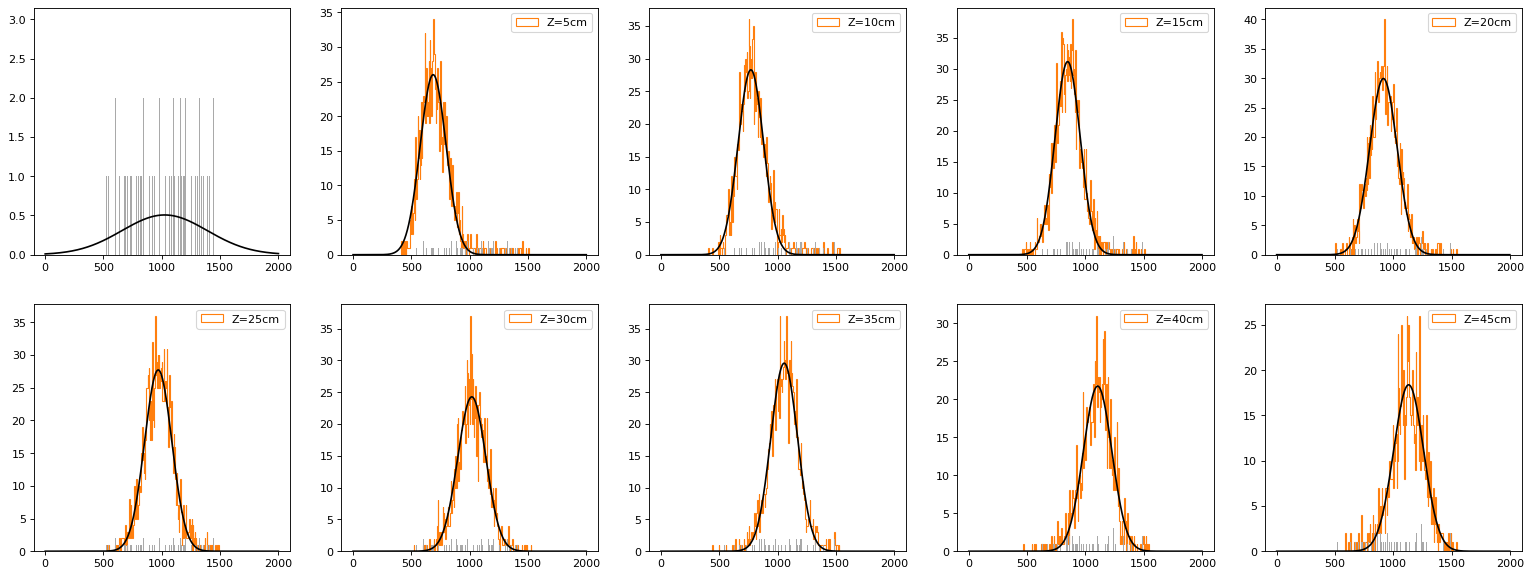

In [30]:
#@title $\sigma_L$ for $1000<R\leq 1100$
Lcoi1100, dLcoi1100 = fit_tsigma(roi.loc[(roi['R']<=1100) & (roi['R']>1000)], 200, 'LSigma')

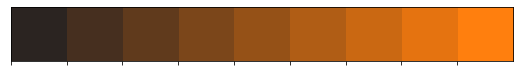

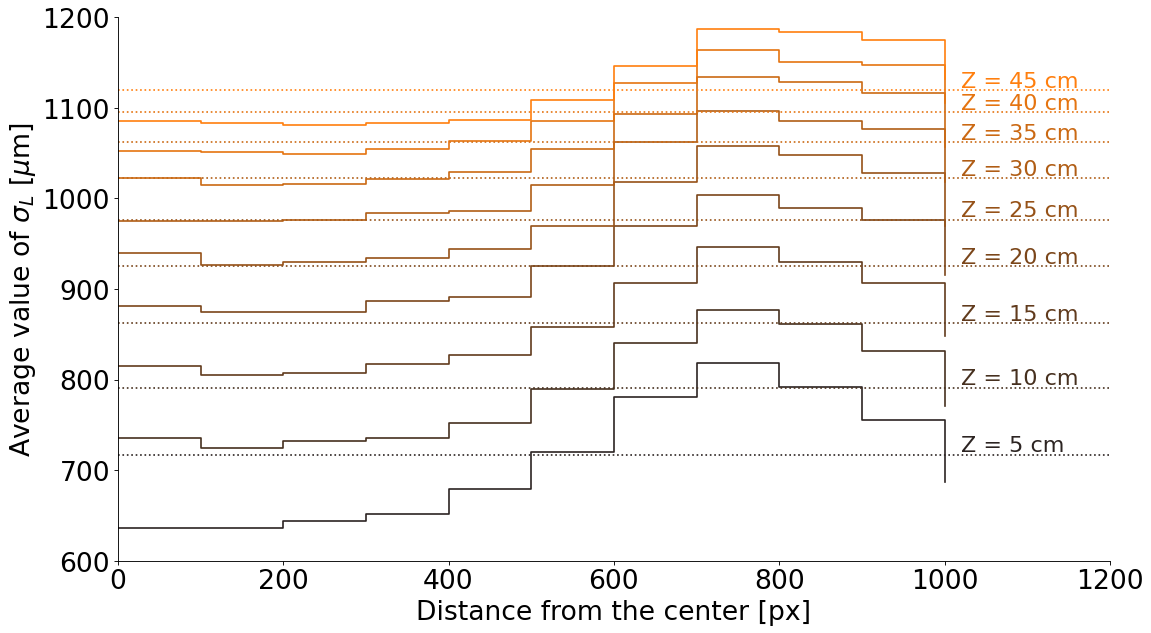

In [31]:
#@title $\sigma_L$ in function of $R$

#@markdown There is a significant difference in $\sigma_T$ for clusters further then 400 px from the center of the image

z = []
r = []
for d in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100]:
  for Z in [5, 10, 15, 20, 25, 30, 35, 40, 45]: 
    z.append(Z)
    r.append(d)
sigma = Lcoi100+Lcoi200+Lcoi300+Lcoi400+Lcoi500+Lcoi600+Lcoi700+Lcoi800+Lcoi900+Lcoi1000+Lcoi1100
dsigma = dLcoi100+dLcoi200+dLcoi300+dLcoi400+dLcoi500+dLcoi600+dLcoi700+dLcoi800+dLcoi900+dLcoi1000+dLcoi1100
sigmaT = pd.DataFrame(list(zip(z, r, sigma, dsigma)), 
                    columns =['z[cm]', 'R[px]', 'TSigma', 'dTSigma']) 

color = get_color(9, 'tab:orange')

fig, (ax) = plt.subplots(figsize=(16,9), dpi= 80, facecolor='w', edgecolor='k') 
i=0
for z in [5, 10, 15, 20, 25, 30, 35, 40, 45]:
  plt.step(sigmaT['R[px]'].loc[sigmaT['z[cm]']==z]-100, sigmaT['TSigma'].loc[sigmaT['z[cm]']==z], color=color[i], where='post')
  plt.text(1020, Lallcoi[i]+10, 'Z = '+str(z)+' cm', fontsize=20, color=color[i], va='center')
  plt.axhline(y=Lallcoi[i], color=color[i], ls=':')
  i = i+1

ax.set_xlim(0,1200)
ax.set_ylim(600,1200)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylabel('Average value of $\sigma_L$ [$\mu$m]', y=0.5, ha='center', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_xlabel('Distance from the center [px]', x=0.5, ha='center', fontsize=24)

plt.show()

# Results

'####################################################################################################'

BACKGROUND
A= 2.49+/-0.22
x0= 907+/-26
sigma= 247+/-30
RMSE =  1.1651996813052332


'####################################################################################################'

Z =  5
A = 422+/-7
x0 =  644.2+/-1.7
sigma =  85.3+/-1.7
RMSE =  21.90498931222298


'####################################################################################################'

Z =  10
A = 391+/-4
x0 =  732.0+/-1.0
sigma =  87.3+/-1.0
RMSE =  12.080243692774308


'####################################################################################################'

Z =  15
A = 439+/-4
x0 =  810.9+/-0.8
sigma =  81.9+/-0.8
RMSE =  11.891702809029253


'####################################################################################################'

Z =  20
A = 466.9+/-3.5
x0 =  879.2+/-0.7
sigma =  79.7+/-0.7
RMSE =  10.668967473967683


'####################################################################################################'

Z =  25
A = 479.7+/-3.3
x0 =  931.4+/-0.6
sigma =  81.4+/-0.6
RMSE =  10.117930579353972


'####################################################################################################'

Z =  30
A = 383.0+/-3.2
x0 =  978.1+/-0.8
sigma =  80.4+/-0.8
RMSE =  10.121185936348619


'####################################################################################################'

Z =  35
A = 438+/-4
x0 =  1018.2+/-0.9
sigma =  82.2+/-0.9
RMSE =  12.374501030756951


'####################################################################################################'

Z =  40
A = 327.1+/-2.1
x0 =  1052.0+/-0.6
sigma =  84.1+/-0.6
RMSE =  6.3298676499562605


'####################################################################################################'

Z =  45
A = 370.2+/-2.8
x0 =  1082.5+/-0.7
sigma =  83.4+/-0.7
RMSE =  8.458282795019443


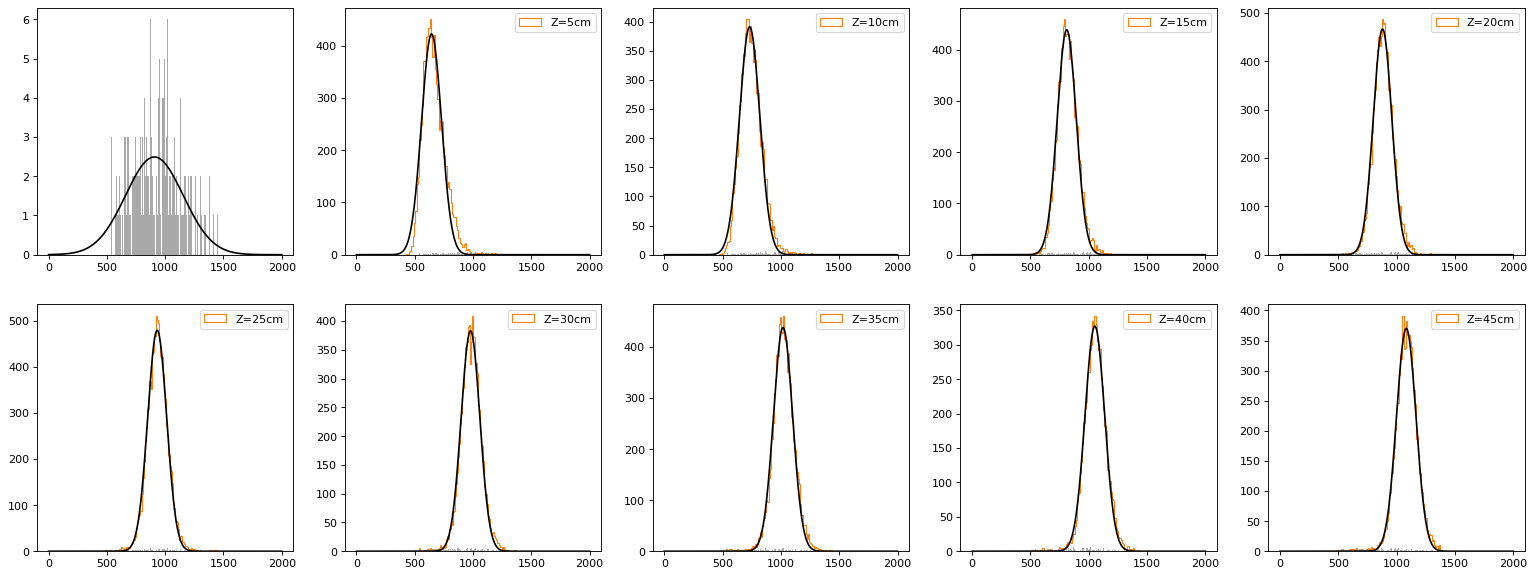

In [32]:
#@title $\sigma_L$ for the uniform region: $0\leq R\leq400$
LSigma, dLSigma = fit_tsigma(roi.loc[(roi['R']<=400)], 100, 'LSigma')

'####################################################################################################'

BACKGROUND
A= 2.62+/-0.21
x0= 711+/-18
sigma= 196+/-20
RMSE =  1.0861167479509564


'####################################################################################################'

Z =  5
A = 408+/-5
x0 =  577.9+/-1.0
sigma =  66.2+/-1.0
RMSE =  15.799336924392613


'####################################################################################################'

Z =  10
A = 408+/-4
x0 =  644.1+/-0.7
sigma =  63.3+/-0.7
RMSE =  12.337979811430559


'####################################################################################################'

Z =  15
A = 483+/-5
x0 =  701.5+/-0.7
sigma =  61.6+/-0.7
RMSE =  14.057286818031402


'####################################################################################################'

Z =  20
A = 551+/-5
x0 =  756.9+/-0.7
sigma =  60.4+/-0.7
RMSE =  14.271627938822299


'####################################################################################################'

Z =  25
A = 492+/-5
x0 =  800.2+/-0.7
sigma =  60.4+/-0.7
RMSE =  13.987577178003582


'####################################################################################################'

Z =  30
A = 424.0+/-3.5
x0 =  838.4+/-0.6
sigma =  62.1+/-0.6
RMSE =  10.37158257350324


'####################################################################################################'

Z =  35
A = 472+/-4
x0 =  876.0+/-0.6
sigma =  63.9+/-0.6
RMSE =  10.571761236985926


'####################################################################################################'

Z =  40
A = 352+/-4
x0 =  908.2+/-0.8
sigma =  63.4+/-0.8
RMSE =  10.644621610918076


'####################################################################################################'

Z =  45
A = 377+/-4
x0 =  933.3+/-0.8
sigma =  66.5+/-0.8
RMSE =  10.852101628582977


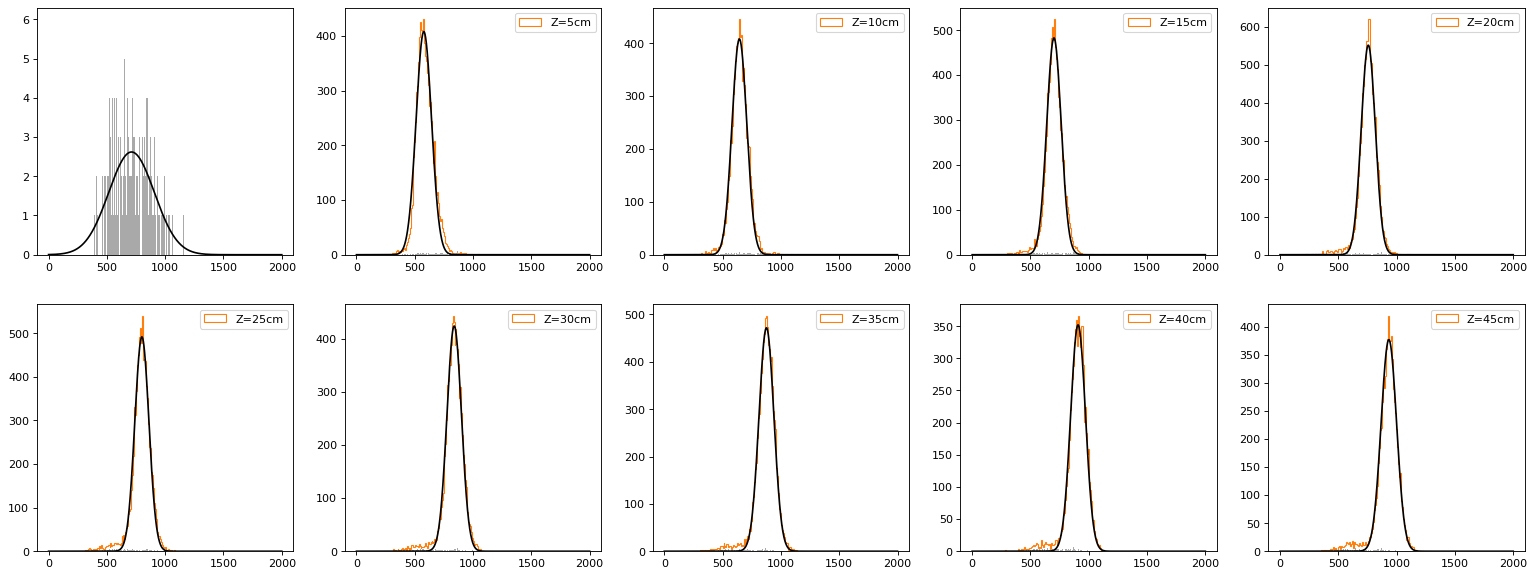

In [33]:
#@title $\sigma_T$ for the uniform region: $0\leq R\leq400$
TSigma, dTSigma = fit_tsigma(roi.loc[(roi['R']<=400)], 100, 'TSigma')

### Fitting the $\sigma_T$ profile in function of $z$

According to the CYGNO paper [[V.C. Antochi et al, 2020]](https://www.researchgate.net/profile/S-Tomassini/publication/341668419_A_GEM-based_Optically_Readout_Time_Projection_Chamber_for_charged_particle_tracking/links/5f2d3ec1299bf13404aba3e7/A-GEM-based-Optically-Readout-Time-Projection-Chamber-for-charged-particle-tracking.pdf), the ionisation electrons drifting in the gas are subjected to a longitudinal and transverse diffusion. Their arrival time and coordinates, $(x,y)$ are correlated with the point where they are produced. The standard deviations of the position at the anode, $\sigma_x$ and $\sigma_y$ are equal to $$\sqrt{\frac{2DZ}{\mu E}}$$
, where $D$ is the diffusion coefficient, $\mu$ the electron mobility and $E$, the drift electric field. 

Avalanche electrons also suffer additional diffusion during multiplication within the GEM holes.

The total diffusion is reflected in the transverse light distribution of each segment of the track: the $\sigma_T$ obtained from the Gaussian and related to the depth of interaction $z$ through: $$\sigma = \sqrt{\sigma_0^2+B^2z}$$
, where the transverse diffusion coefficient $B$ in the gas is 130 $\mu m\sqrt{cm}^{-1}$ (Garfield simulation), whereas the intercept at zero, $\sigma_0$, illustrates the contribution of the electron avalanche propagation in the GEM stack. 

Transverse Diffusion
Gas Diffusion =  117+/-29
GEM Diffusion =  (5.3+/-1.5)e+02
RMSE =  9.112568277625352
r2 =  0.9937172717581367

Longitudinal Diffusion
Gas Diffusion =  136+/-34
GEM Diffusion =  (6.2+/-1.8)e+02
RMSE =  18.951229704353945
r2 =  0.9819825283041345


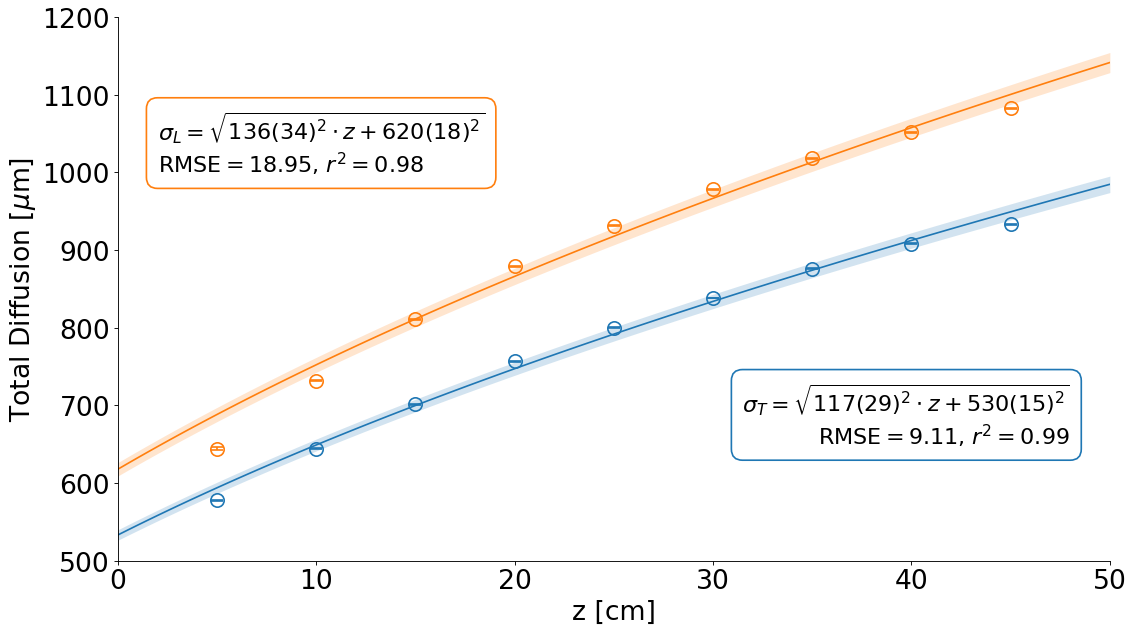

In [41]:
#@title Longitudinal and Transverse Diffusion Fit to $f(x)=\sqrt{\sigma_0^2+B^2 z}$
z = [5, 10, 15, 20, 25, 30, 35, 40, 45]

def func(x, b, c):
  return np.sqrt(x*b+c)

x = np.linspace(0,50, 100)

fig, (ax) = plt.subplots(figsize=(16,9), dpi= 80, facecolor='w', edgecolor='k') 

# Transverse Diffusion
plt.errorbar(z, TSigma, yerr=dTSigma, color='none', marker='o', markersize=12, 
            markeredgecolor='tab:blue', markeredgewidth=1.5, ecolor='tab:blue', elinewidth=1.5, capsize=5, capthick=1.5, label='$\sigma_T$')

popt, pcov = curve_fit(func, z, TSigma, p0=[100, 100], absolute_sigma=True, sigma=3*np.asarray(dTSigma))
ycalc = func(x, *popt)
pcov = np.sqrt(np.diag(pcov))
bound_upper = func(x, *(popt + 3*pcov))
bound_lower = func(x, *(popt - 3*pcov))
print('Transverse Diffusion')
print('Gas Diffusion = ', ufloat(np.sqrt(popt[0]), 3*np.sqrt(pcov[0])))
print('GEM Diffusion = ', ufloat(np.sqrt(popt[1]), 3*np.sqrt(pcov[1])))
rmse = np.sqrt(mean_squared_error(TSigma, func(np.asarray(z), *popt)))
print('RMSE = ', rmse)
r2 = r2_score(TSigma, func(np.asarray(z), *popt))
print('r2 = ', r2)
plt.plot(x, ycalc, color='tab:blue')
plt.fill_between(x, bound_lower, bound_upper, color='tab:blue', alpha=0.2, lw=0)
plt.text(48, 650, '$\sigma_T=\sqrt{117(29)^2\cdot z+530(15)^2}$ \nRMSE$ = 9.11$, $r^2=0.99$',
         fontsize=20, ha='right', bbox=dict(facecolor='none', edgecolor='tab:blue', boxstyle='round,pad=0.5', lw=1.5))

# Longitudinal Diffusion
plt.errorbar(z, LSigma, yerr=dLSigma, color='none', marker='o', markersize=12, 
            markeredgecolor='tab:orange', markeredgewidth=1.5, ecolor='tab:orange', elinewidth=1.5, capsize=5, capthick=1.5, label='$\sigma_L$')
popt, pcov = curve_fit(func, z, LSigma, p0=[100, 100], absolute_sigma=True, sigma=3*np.asarray(dLSigma))
ycalc = func(x, *popt)
pcov = np.sqrt(np.diag(pcov))
bound_upper = func(x, *(popt + 3*pcov))
bound_lower = func(x, *(popt - 3*pcov))
print('\nLongitudinal Diffusion')
print('Gas Diffusion = ', ufloat(np.sqrt(popt[0]), 3*np.sqrt(pcov[0])))
print('GEM Diffusion = ', ufloat(np.sqrt(popt[1]), 3*np.sqrt(pcov[1])))
rmse = np.sqrt(mean_squared_error(LSigma, func(np.asarray(z), *popt)))
print('RMSE = ', rmse)
r2 = r2_score(LSigma, func(np.asarray(z), *popt))
print('r2 = ', r2)
plt.plot(x, ycalc, color='tab:orange')
plt.fill_between(x, bound_lower, bound_upper, color='tab:orange', alpha=0.2, lw=0)
plt.text(2, 1000, '$\sigma_L=\sqrt{136(34)^2\cdot z+620(18)^2}$ \nRMSE$ = 18.95$, $r^2=0.98$',
         fontsize=20, bbox=dict(facecolor='none', edgecolor='tab:orange', boxstyle='round,pad=0.5', lw=1.5))

ax.set_xlim(0,50)
ax.set_ylim(500,1200)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylabel('Total Diffusion [$\mu$m]', y=0.5, ha='center', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_xlabel('z [cm]', x=0.5, ha='center', fontsize=24)

#plt.legend(loc='best', fontsize=20)
plt.show()

Transverse Diffusion
Gas Diffusion =  81.9+/-1.7
GEM Diffusion =  389+/-9
RMSE =  3.5075376529450883
r2 =  0.9990691678655786

Longitudinal Diffusion
Gas Diffusion =  98.0+/-2.1
GEM Diffusion =  435+/-11
RMSE =  7.49486771324464
r2 =  0.9971819609894134


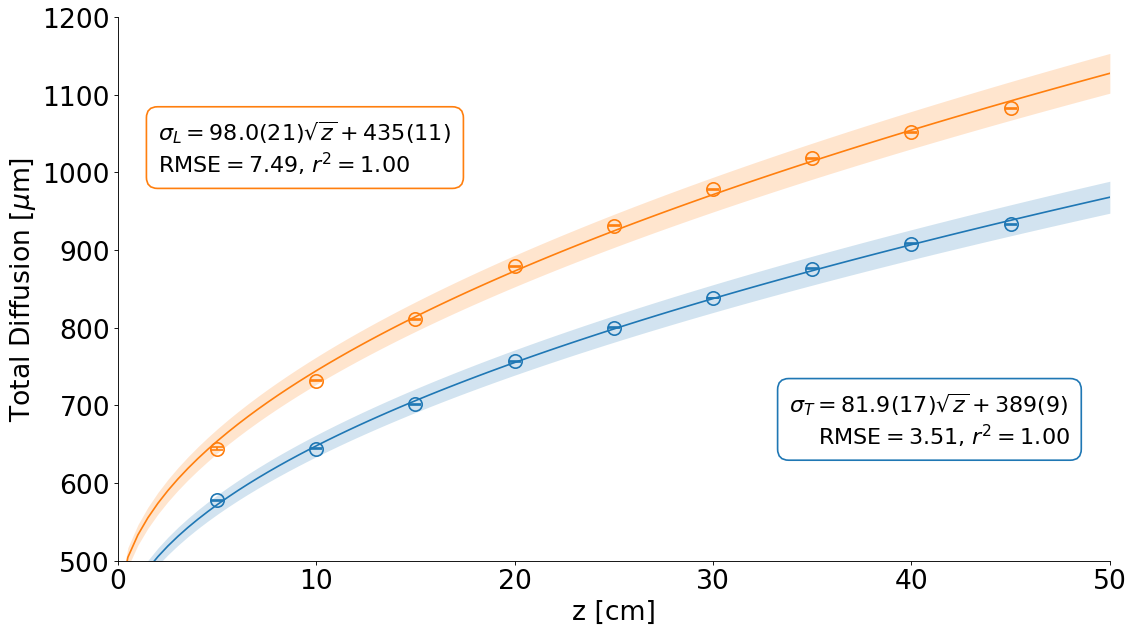

In [42]:
#@title Longitudinal and Transverse Diffusion Fit to $f(x)=m\sqrt{x}+b$
#@markdown Seems to give a better fit
z = [5, 10, 15, 20, 25, 30, 35, 40, 45]

def func(x, b, c):
  return np.sqrt(x)*b+c

x = np.linspace(0,50, 100)

fig, (ax) = plt.subplots(figsize=(16,9), dpi= 80, facecolor='w', edgecolor='k') 

# Transverse Diffusion
plt.errorbar(z, TSigma, yerr=dTSigma, color='none', marker='o', markersize=12, 
            markeredgecolor='tab:blue', markeredgewidth=1.5, ecolor='tab:blue', elinewidth=1.5, capsize=5, capthick=1.5, label='$\sigma_T$')

popt, pcov = curve_fit(func, z, TSigma, p0=[100, 100], absolute_sigma=True, sigma=3*np.asarray(dTSigma))
ycalc = func(x, *popt)
pcov = np.sqrt(np.diag(pcov))
bound_upper = func(x, *(popt + 3*pcov))
bound_lower = func(x, *(popt - 3*pcov))
print('Transverse Diffusion')
print('Gas Diffusion = ', ufloat(popt[0], 3*pcov[0]))
print('GEM Diffusion = ', ufloat(popt[1], 3*pcov[1]))
rmse = np.sqrt(mean_squared_error(TSigma, func(np.asarray(z), *popt)))
print('RMSE = ', rmse)
r2 = r2_score(TSigma, func(np.asarray(z), *popt))
print('r2 = ', r2)
plt.plot(x, ycalc, color='tab:blue')
plt.fill_between(x, bound_lower, bound_upper, color='tab:blue', alpha=0.2, lw=0)
plt.text(48, 650, '$\sigma_T=81.9(17)\sqrt{z}+389(9)$ \nRMSE$ = 3.51$, $r^2=1.00$',
         fontsize=20, ha='right', bbox=dict(facecolor='none', edgecolor='tab:blue', boxstyle='round,pad=0.5', lw=1.5))

# Longitudinal Diffusion
plt.errorbar(z, LSigma, yerr=dLSigma, color='none', marker='o', markersize=12, 
            markeredgecolor='tab:orange', markeredgewidth=1.5, ecolor='tab:orange', elinewidth=1.5, capsize=5, capthick=1.5, label='$\sigma_L$')
popt, pcov = curve_fit(func, z, LSigma, p0=[100, 100], absolute_sigma=True, sigma=3*np.asarray(dLSigma))
ycalc = func(x, *popt)
pcov = np.sqrt(np.diag(pcov))
bound_upper = func(x, *(popt + 3*pcov))
bound_lower = func(x, *(popt - 3*pcov))
print('\nLongitudinal Diffusion')
print('Gas Diffusion = ', ufloat(popt[0], 3*pcov[0]))
print('GEM Diffusion = ', ufloat(popt[1], 3*pcov[1]))
rmse = np.sqrt(mean_squared_error(LSigma, func(np.asarray(z), *popt)))
print('RMSE = ', rmse)
r2 = r2_score(LSigma, func(np.asarray(z), *popt))
print('r2 = ', r2)
plt.plot(x, ycalc, color='tab:orange')
plt.fill_between(x, bound_lower, bound_upper, color='tab:orange', alpha=0.2, lw=0)
plt.text(2, 1000, '$\sigma_L=98.0(21)\sqrt{z}+435(11)$ \nRMSE$ = 7.49$, $r^2=1.00$',
         fontsize=20, bbox=dict(facecolor='none', edgecolor='tab:orange', boxstyle='round,pad=0.5', lw=1.5))

ax.set_xlim(0,50)
ax.set_ylim(500,1200)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylabel('Total Diffusion [$\mu$m]', y=0.5, ha='center', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=24)
ax.set_xlabel('z [cm]', x=0.5, ha='center', fontsize=24)

#plt.legend(loc='best', fontsize=20)
plt.show()